[Source Code](https://jovian.ai/aakashns/python-gradient-boosting-machines) python-gradient-boosting-machines by aakashns

[Dataset Link](https://www.kaggle.com/c/rossmann-store-sales) Rossmann dataset

[Spreadsheet](https://docs.google.com/spreadsheets/d/1gPCAvI8nBfdIp6gs7ndkWE5nzoeVixUUJD0VW_7FB2s/edit?usp=sharing)  to keep track of experiments, feature engineering ideas and results

# **Todo**

* Read Top Scores Codes
* Load Data
* Understand Data
* Feature Engineering
* Select Columns
* Preprocess Data
* Select Model
* Tune Hyperparameter
* Advanced Strategies
* Beat 90% of Kaggle leaderboard


# **Infos**

The following topics are covered:

- Downloading a real-world dataset from a Kaggle competition
- Performing **feature engineering** and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with **KFold cross validation** and **ensembling results**
- Configuring the gradient boosting model and tuning hyperparamters

**Problem Statement**

> Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.
>
>
> With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.
>
> View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data

* Store - a unique Id for each store

* StateHoliday - indicates a state holiday. **Normally** all stores, with few exceptions, are **closed on state holidays**. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of **public schools**

* StoreType - differentiates between 4 different store models: a, b, c, d

* Assortment - describes an assortment level: a = basic, b = extra, c = extended

    > In this context, "basic" would likely indicate a limited number of variations or options, while "extra" would imply a larger selection of variations within the same product category.

    > An extended assortment is a wider range, offering a broad selection of products and variations. It might include new product lines, more categories, or significantly expanded variations within existing categories

* CompetitionDistance - distance in meters to the nearest competitor store

* Promo - indicates whether a store is running a promo on that day

* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# **Imports**

In [1]:
!pip list | grep xgboost # check xgboost lib version

xgboost                               2.1.4


In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import WeekOfMonth

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import root_mean_squared_error

from xgboost import XGBRegressor, plot_tree, plot_importance

In [4]:
%matplotlib inline
plt.style.use("seaborn-v0_8-dark")

# **Env**

In [5]:
explore = True

# **Load Data**

In [6]:
import gdown

# Replace with your Google Drive shareable link
url = 'https://drive.google.com/file/d/1PogAVq1OtCFCU37GKUN-LPfjuGML6npk/view?usp=sharing'

# Convert to the direct download link
file_id = url.split('/d/')[1].split('/')[0]
direct_url = f'https://drive.google.com/uc?id={file_id}'

# Download
gdown.download(direct_url, 'Rossmann.zip', quiet=False)

!unzip -o /content/Rossmann.zip -d /content/Rossmann

Downloading...
From: https://drive.google.com/uc?id=1PogAVq1OtCFCU37GKUN-LPfjuGML6npk
To: /content/Rossmann.zip
100%|██████████| 7.33M/7.33M [00:00<00:00, 33.6MB/s]


Archive:  /content/Rossmann.zip
  inflating: /content/Rossmann/sample_submission.csv  
  inflating: /content/Rossmann/store.csv  
  inflating: /content/Rossmann/test.csv  
  inflating: /content/Rossmann/train.csv  


In [7]:
train_data = pd.read_csv("/content/Rossmann/train.csv", low_memory=False)
test_data = pd.read_csv("/content/Rossmann/test.csv")
store_data = pd.read_csv("/content/Rossmann/store.csv")
sample_submission_data = pd.read_csv("/content/Rossmann/sample_submission.csv")

In [8]:
train_data.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1


In [9]:
test_data.head(2)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0


In [10]:
store_data.head(2)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


# **Early Process Data**

In [11]:
# Fixing StateHoliday mixed types
train_data["StateHoliday"] = train_data["StateHoliday"].replace({0: '0'})
train_data["StateHoliday"].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [12]:
# Inner Join Train and Store
train_store_data = pd.merge(train_data, store_data, how="left", on="Store")
test_store_data = pd.merge(test_data, store_data, how="left", on="Store")
train_store_data.head(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [13]:
train_store_data.isna().sum()[lambda x: x > 0]

,0
CompetitionDistance,2642
CompetitionOpenSinceMonth,323348
CompetitionOpenSinceYear,323348
Promo2SinceWeek,508031
Promo2SinceYear,508031
PromoInterval,508031


# **Visualize** P1
* Samples with Open==0 condition are excluded because sales is **always** equal to zero when Open==0

In [14]:
exclude_cols = ["CompetitionDistance", "Customers", "Sales", "Date", "Store"]

## BarPlot

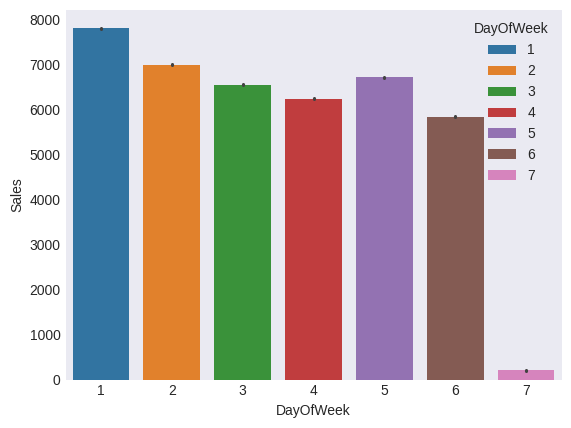

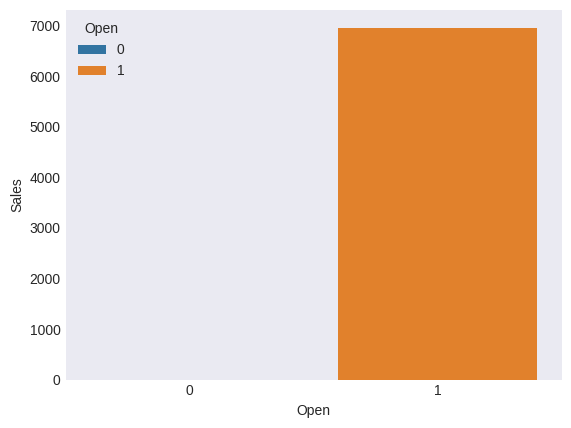

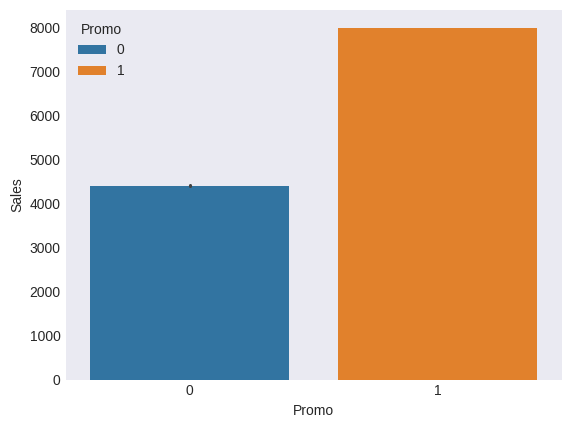

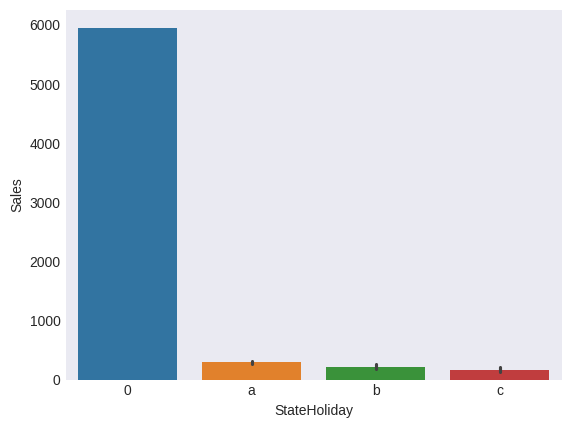

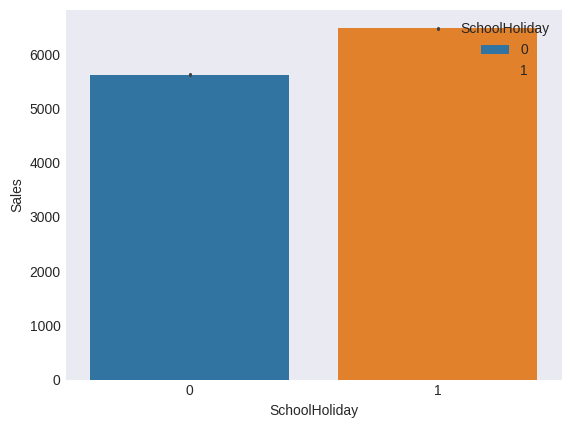

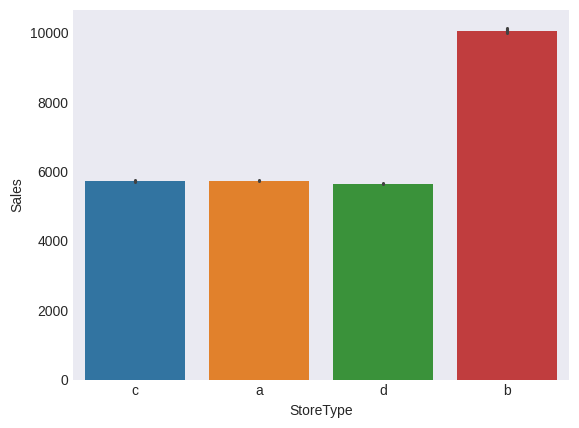

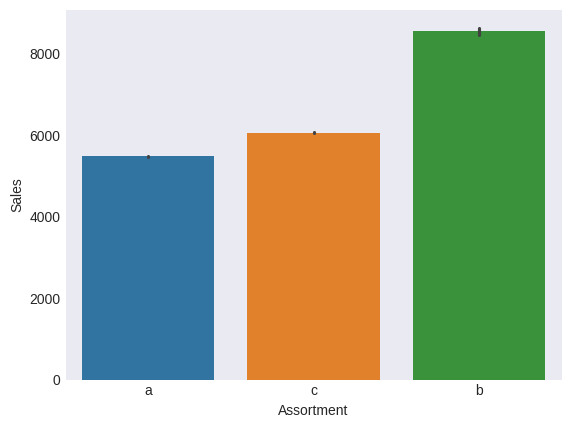

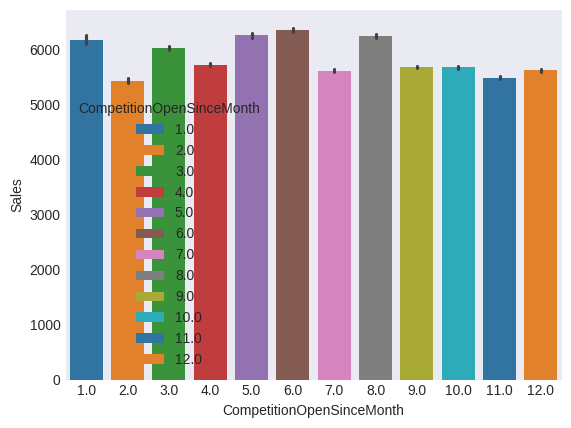

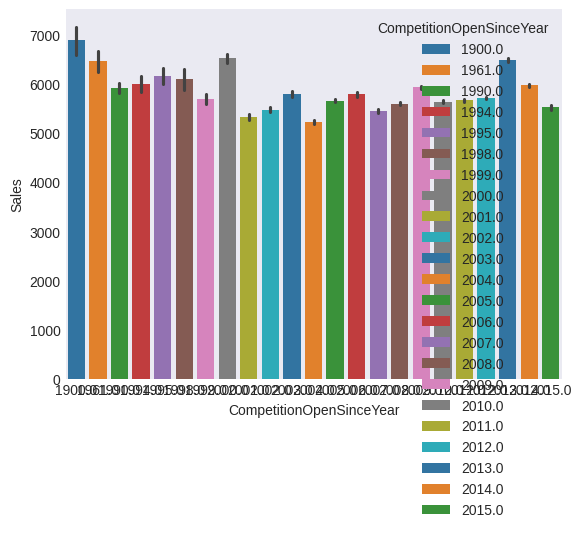

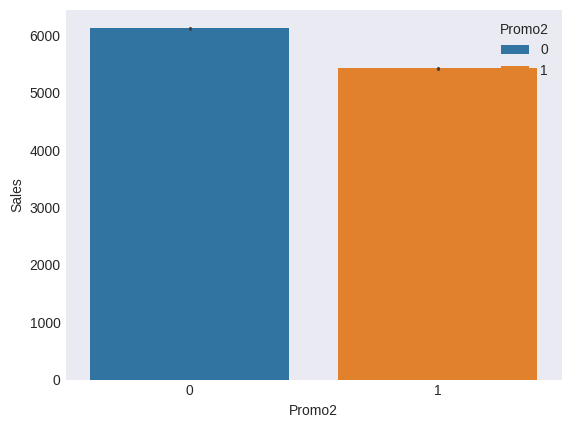

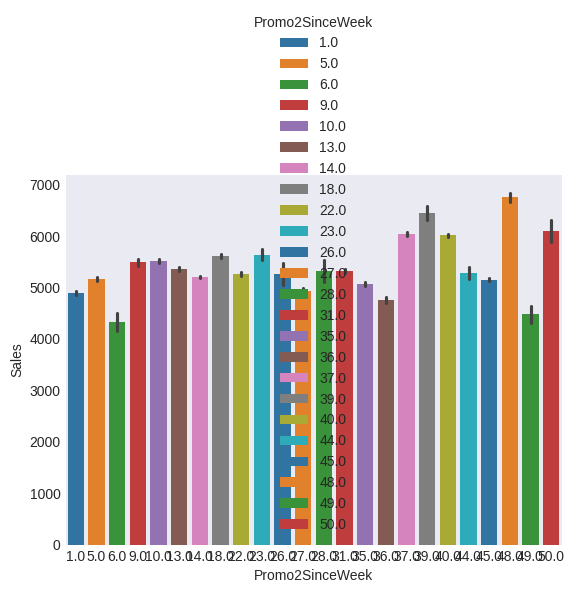

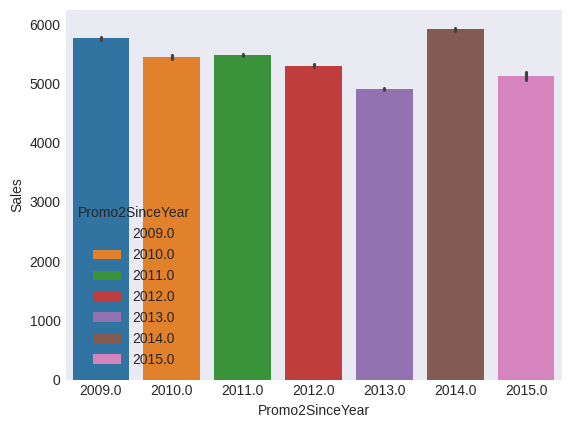

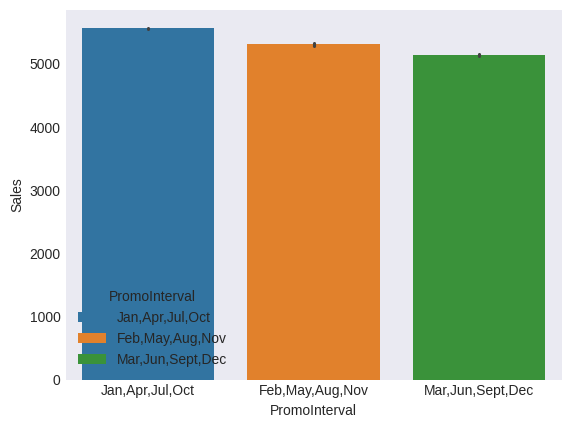

In [15]:
cat_cols = [col for col in train_store_data.columns if col not in exclude_cols]
if explore:
    for col in cat_cols:
        sns.barplot(data=train_store_data, x=col, y="Sales", hue=col, palette="tab10", legend=False)
        plt.show()

Base on above plots there is no sales when store is close

### Open

In [16]:
train_store_data[train_store_data["Open"] == 0]["Sales"].sum()

np.int64(0)

Conclusion: When store is closed, sales equal to zero, so we can exclude these samples and handle them manually.

In [17]:
# exclude Open == 0 samples
train_store_data = train_store_data[train_store_data["Open"] == 1]
train_store_data.shape

(844392, 18)

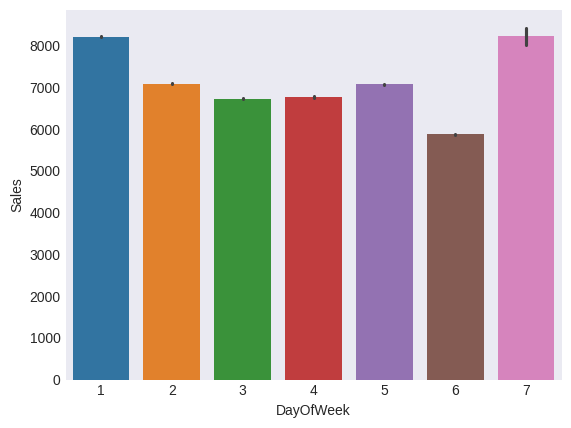

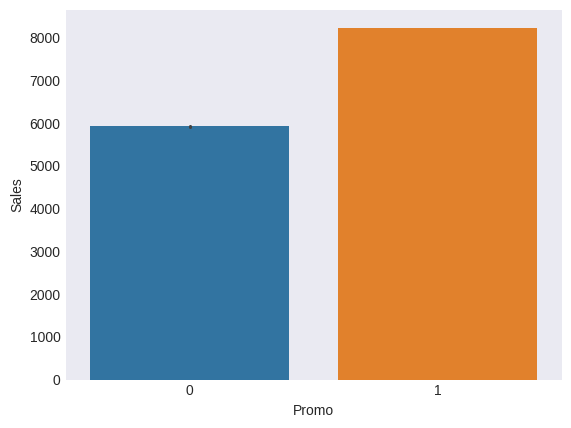

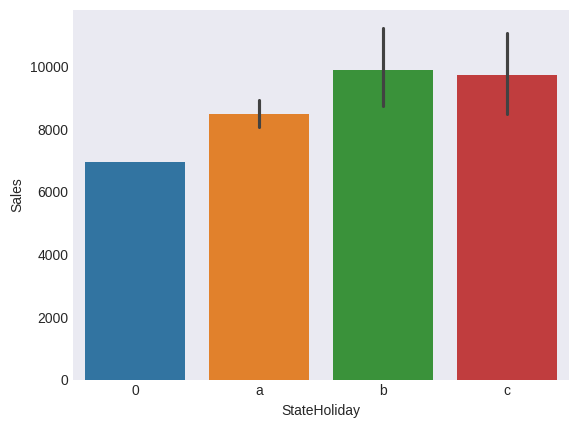

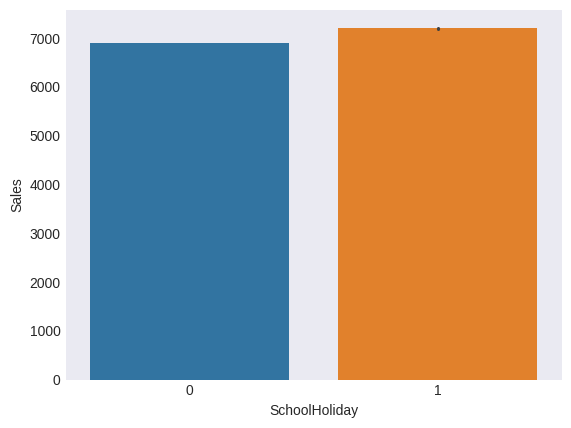

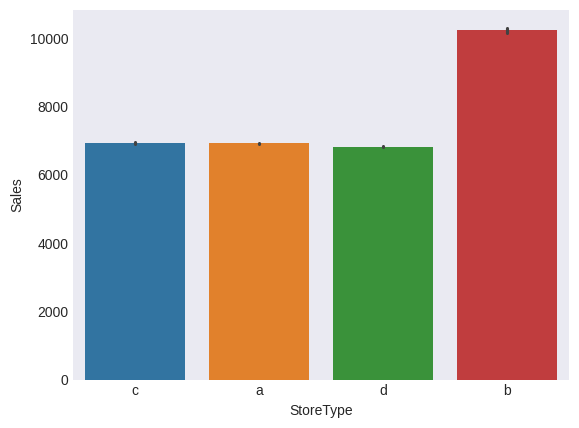

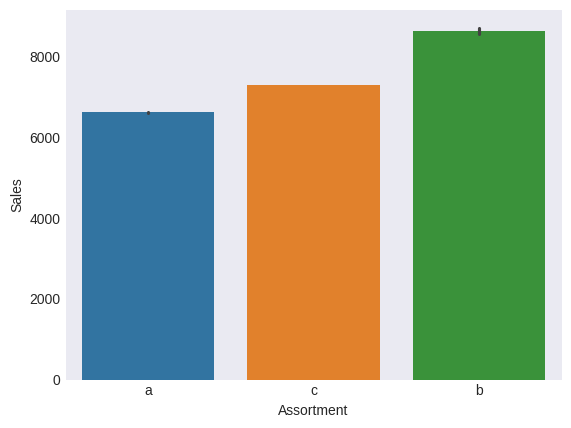

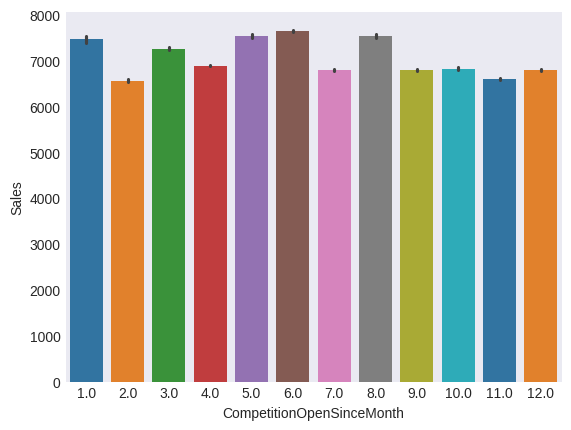

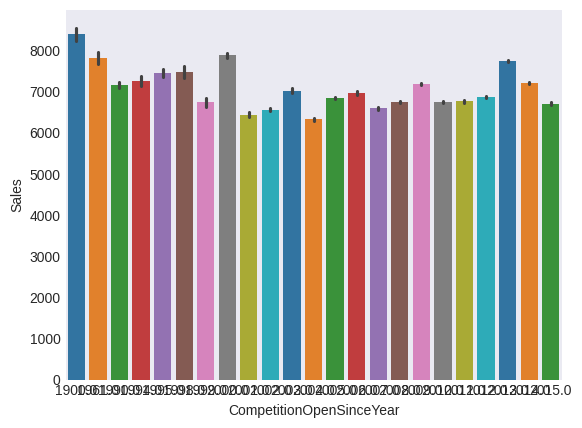

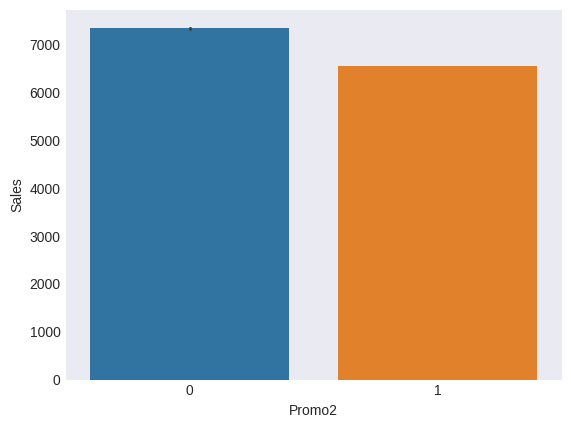

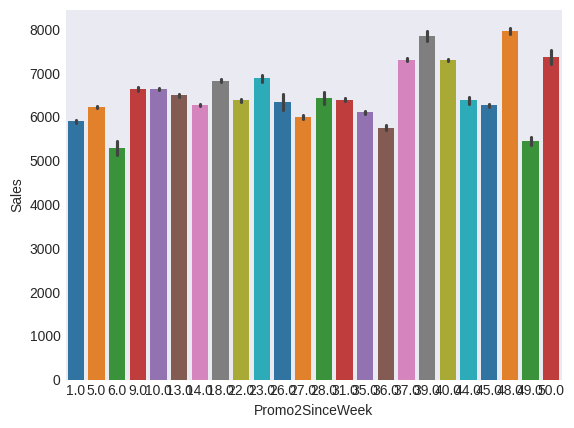

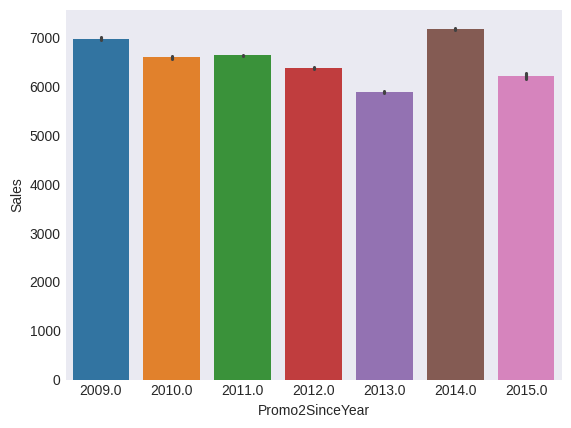

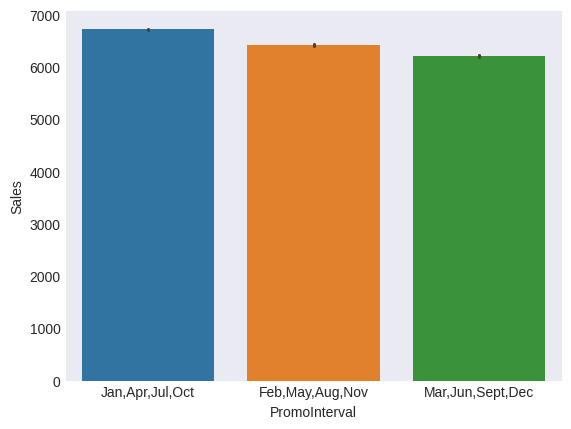

In [18]:
cat_cols = [col for col in train_store_data.columns if col not in exclude_cols + ["Open"]]
if explore:
    for col in cat_cols:
        sns.barplot(data=train_store_data, x=col, y="Sales", hue=col, palette="tab10", legend=False)
        plt.show()

## Histogram

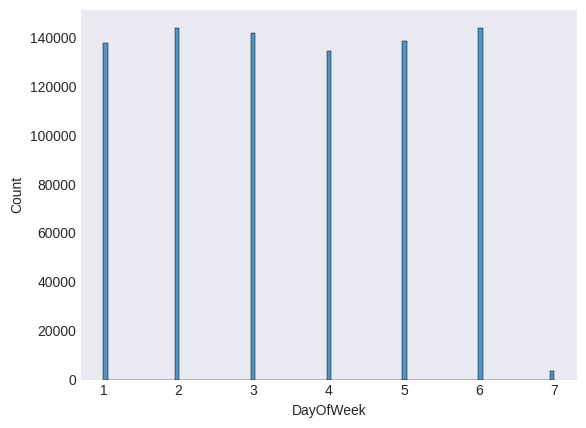

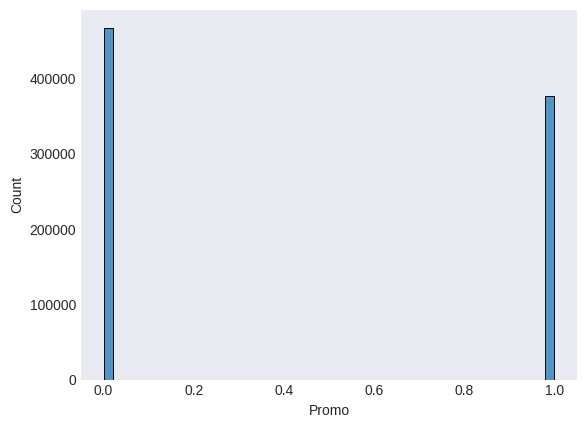

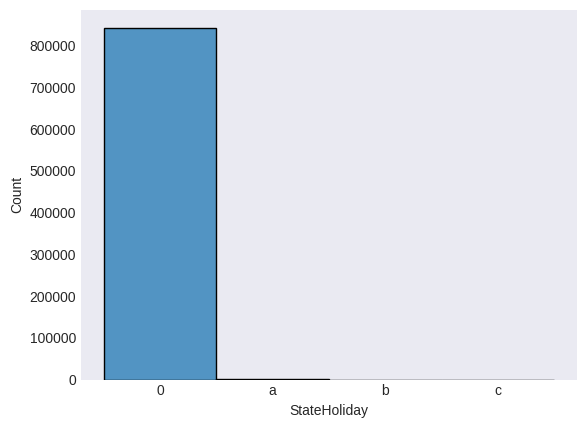

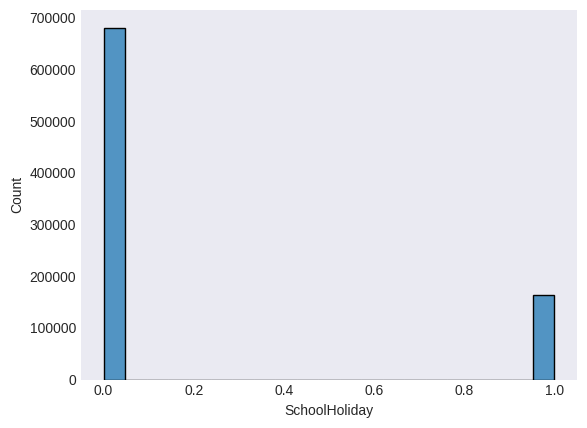

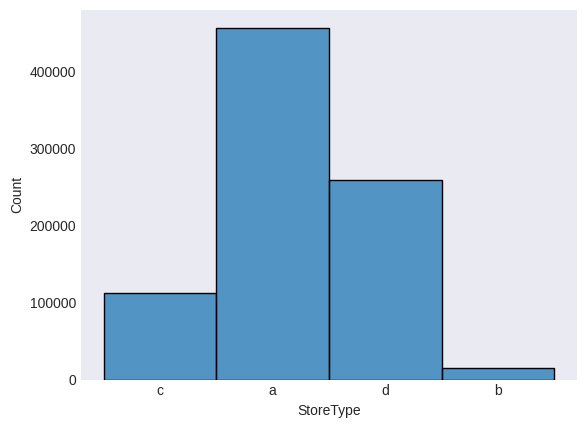

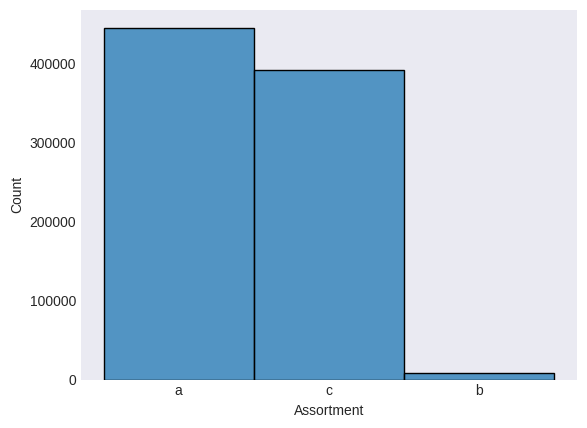

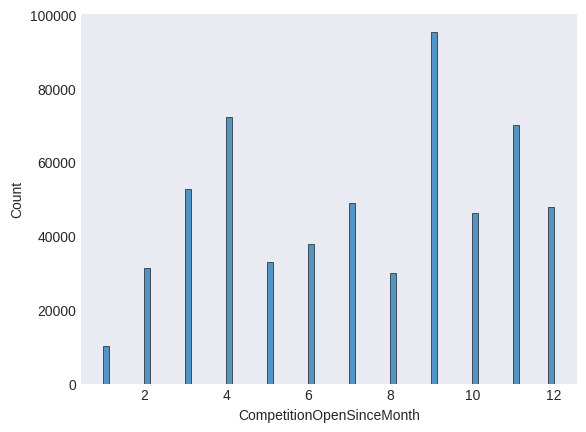

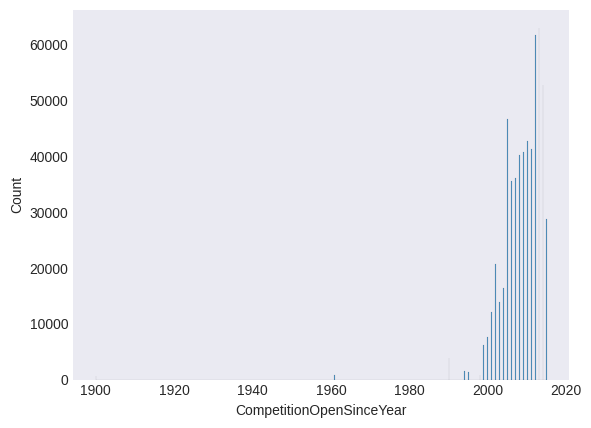

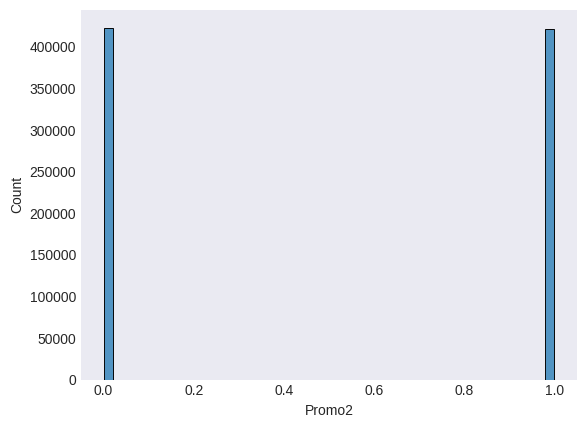

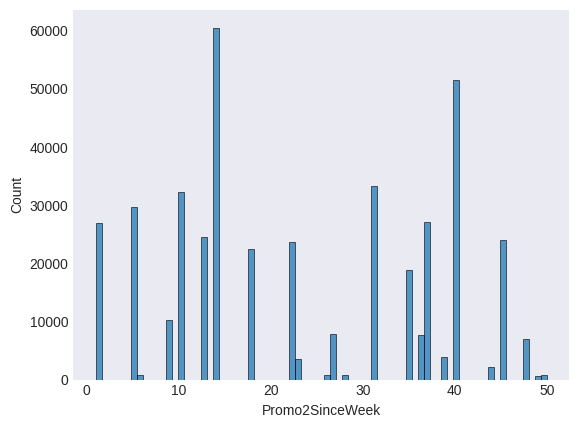

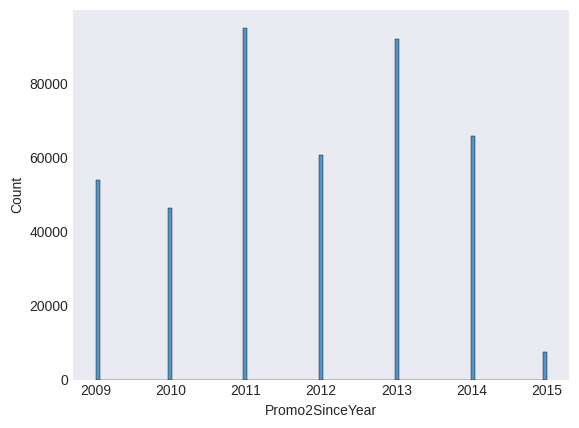

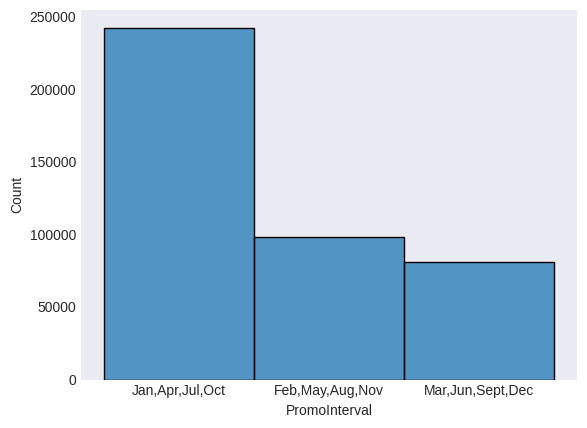

In [19]:
cat_cols = [col for col in train_store_data.columns if col not in exclude_cols + ["Open"]]
if explore:
    for col in cat_cols:
        sns.histplot(data=train_store_data, x=col)
        plt.show()

## BoxPlot

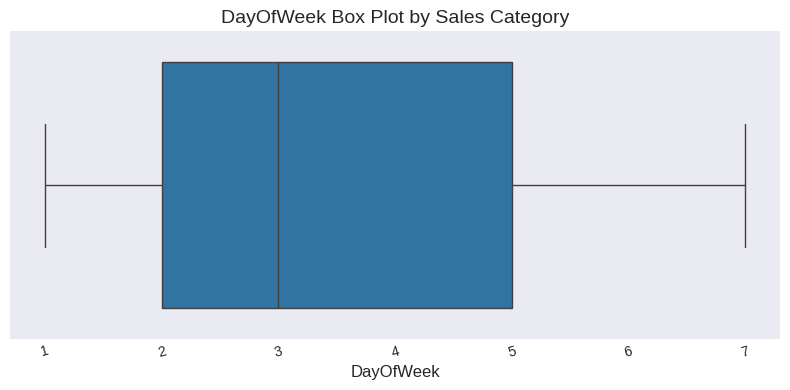

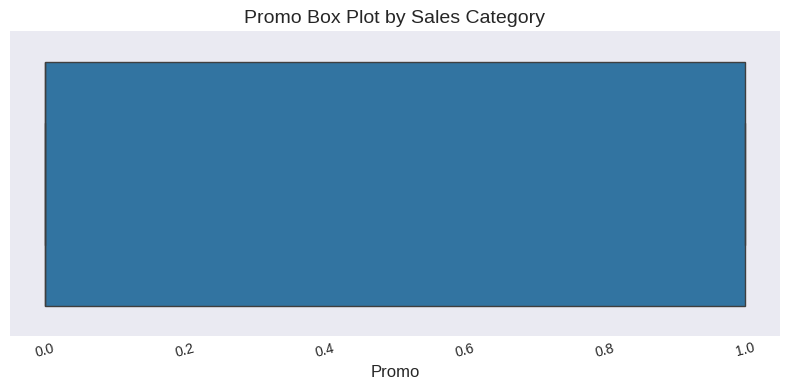

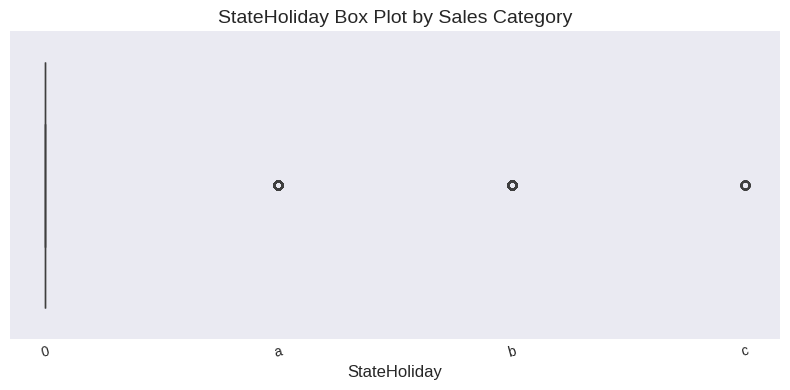

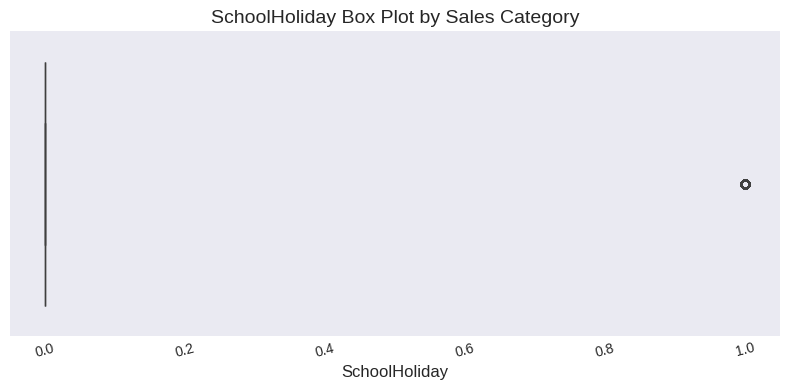

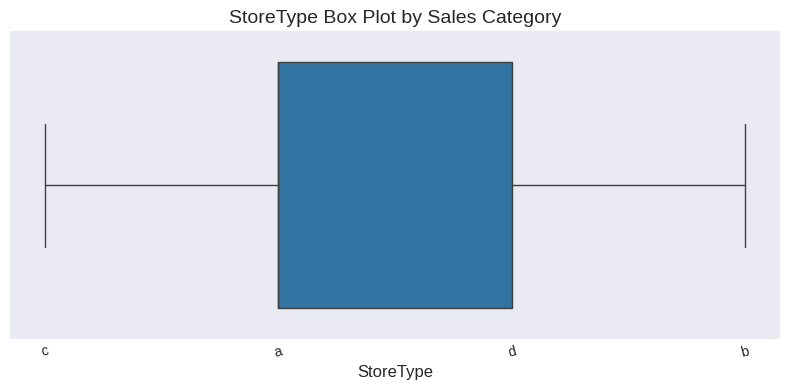

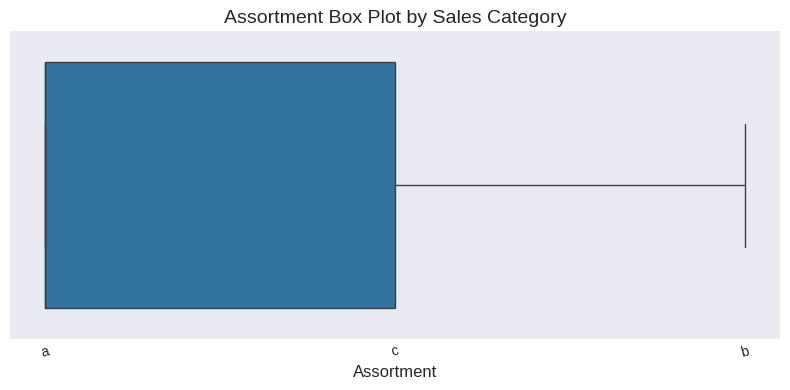

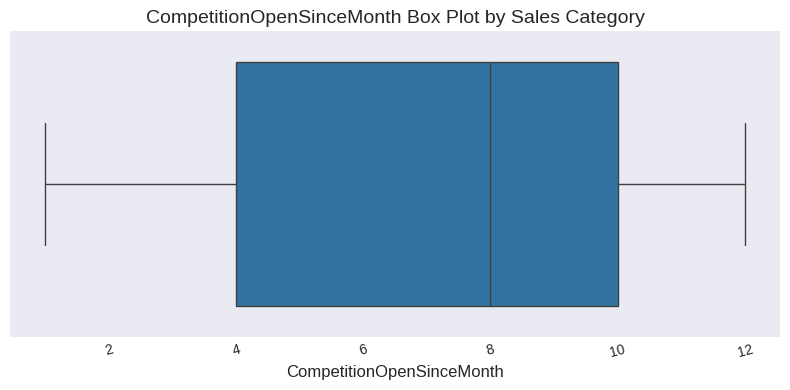

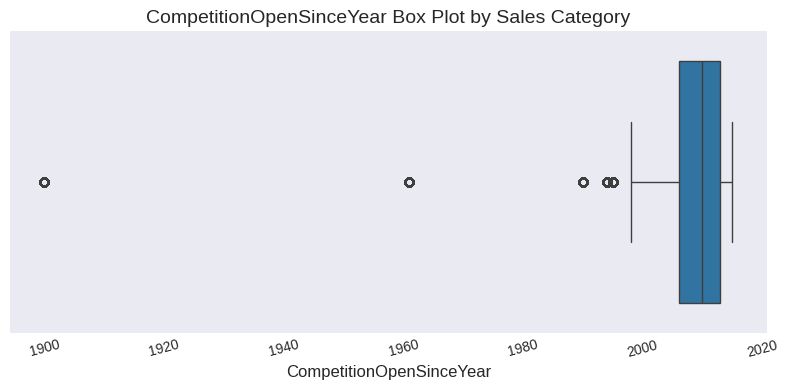

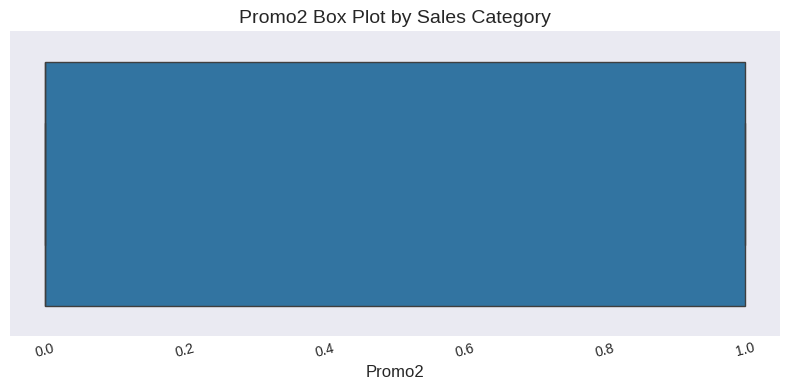

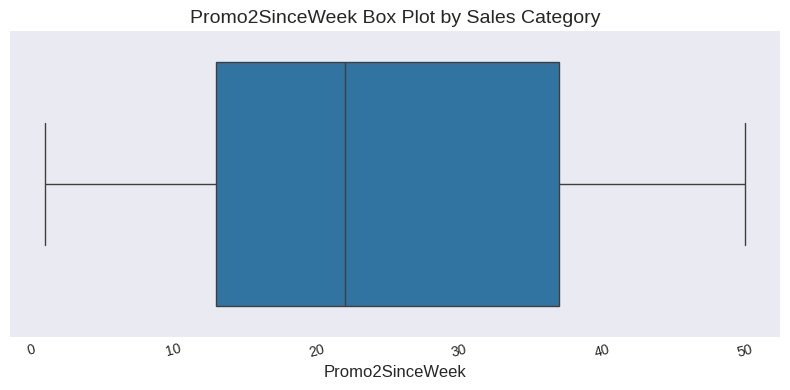

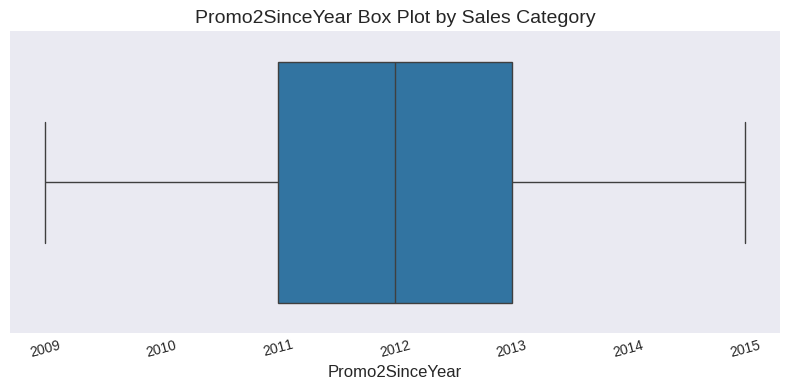

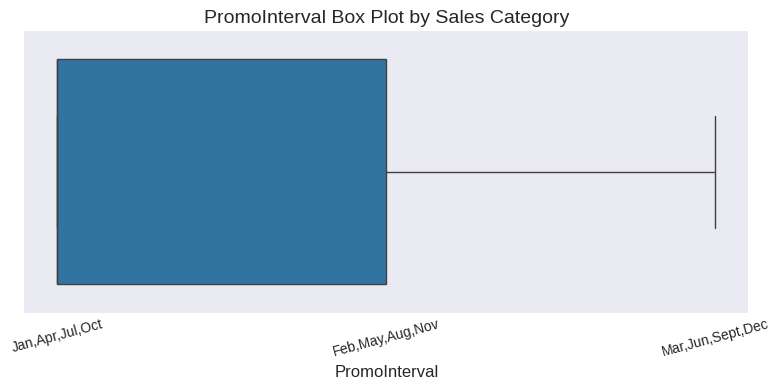

In [20]:
cat_cols = [col for col in train_store_data.columns if col not in exclude_cols + ["Open"]]
# Loop through each column
for col in cat_cols:
    plt.figure(figsize=(8, 4))  # Bigger figure for better readability

    # Plot with improved settings
    sns.boxplot(data=train_store_data, x=col)

    # Add titles and labels
    plt.title(f"{col} Box Plot by Sales Category", fontsize=14)
    plt.xlabel(col, fontsize=12)

    # Rotate x-axis labels if needed
    plt.xticks(rotation=15)

    # Show plot
    plt.tight_layout()
    plt.show()

# **Feature Engineering**

Take a look at the available columns, and figure out if it's possible to create new columns or apply any useful transformations.

[Spreadsheet ](https://docs.google.com/spreadsheets/d/1gPCAvI8nBfdIp6gs7ndkWE5nzoeVixUUJD0VW_7FB2s/edit?usp=sharing) to keep track of experiments, feature engineering ideas and results

In [14]:
train_store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

## Store Open/Close

Samples with Open==0(Closed Store) condition are excluded from dataset in [**Visualize** P1 BarPlot](#scrollTo=Open) section.

Instead of trying to model this relationship, it would be better to hard-code it in our predictions, and remove the rows where the store is closed. We won't remove any rows from the test set, since we need to make predictions for every row.

In [15]:
train_store_data = train_store_data[train_store_data["Open"] == 1]
train_store_data.shape

(844392, 18)

## Date

In [16]:
# Convert Date to pd.to_datetime
def split_date(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Day"] = df.Date.dt.day
    df["WeekOfYear"] = df.Date.dt.isocalendar().week
    df["WeekOfMonth"] = (df["Date"] - df["Date"].apply(lambda x: x - WeekOfMonth(weekday=x.weekday()))).dt.days // 7 + 1

In [17]:
split_date(train_store_data)
split_date(test_store_data)

In [18]:
train_store_data[["Date", "WeekOfYear", "WeekOfMonth"]].sample(5)

,Date,WeekOfYear,WeekOfMonth
250043,2014-12-17,51,3
939976,2013-03-11,11,2
906274,2013-04-10,15,2
751594,2013-08-27,35,4
923658,2013-03-25,13,4


## Store

Because 2015 Samples are going to be validation set we use 2014 to get mean of sales(No feature leakage)

In [19]:
train_store_data[train_store_data["Year"] == 2014]["Date"].describe()

,Date
count,310417
mean,2014-06-23 21:57:24.990448640
min,2014-01-01 00:00:00
25%,2014-03-24 00:00:00
50%,2014-06-19 00:00:00
75%,2014-09-22 00:00:00
max,2014-12-31 00:00:00


In [20]:
store_sales_2013 = train_store_data[train_store_data["Year"] == 2013].groupby(["Store"])["Sales"].mean()
store_sales_2013

,Sales
Store,
1,4921.254125
2,4895.276316
3,7047.235099
4,9383.773026
5,4718.365449
...,...
1111,5447.605960
1112,11369.635762
1113,6542.315789


In [21]:
store_sales_2014 = train_store_data[train_store_data["Year"] == 2014].groupby(["Store"])["Sales"].mean()
store_sales_2014

,Sales
Store,
1,4730.719472
2,4988.263158
3,6864.069536
4,9776.279605
5,4657.168874
...,...
1111,5255.066225
1112,9690.844371
1113,6721.286184


In [22]:
train_store_data = train_store_data.merge(right=store_sales_2014, on="Store", how="left")
train_store_data.rename(columns={"Sales_y": "Sales_Mean_2014", "Sales_x": "Sales"}, inplace=True)

train_store_data = train_store_data.merge(right=store_sales_2013, on="Store", how="left")
train_store_data.rename(columns={"Sales_y": "Sales_Mean_2013", "Sales_x": "Sales"}, inplace=True)

train_store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth,Sales_Mean_2014,Sales_Mean_2013
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,5,4730.719472,4921.254125
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5,4988.263158,4895.276316
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,5,6864.069536,7047.235099
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,NaN,NaN,NaN,2015,7,31,31,5,9776.279605,9383.773026
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,NaN,NaN,NaN,2015,7,31,31,5,4657.168874,4718.365449


In [23]:
test_store_data = test_store_data.merge(right=store_sales_2014, on="Store", how="left")
test_store_data.rename(columns={"Sales": "Sales_Mean_2014"}, inplace=True)

test_store_data = test_store_data.merge(right=store_sales_2013, on="Store", how="left")
test_store_data.rename(columns={"Sales": "Sales_Mean_2013"}, inplace=True)
test_store_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,WeekOfMonth,Sales_Mean_2014,Sales_Mean_2013
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,...,NaN,NaN,NaN,2015,9,17,38,3,4730.719472,4921.254125
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,...,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,9,17,38,3,6864.069536,7047.235099
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,...,NaN,NaN,NaN,2015,9,17,38,3,8975.026230,8570.265574
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,...,NaN,NaN,NaN,2015,9,17,38,3,5558.223684,5073.233553
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,...,NaN,NaN,NaN,2015,9,17,38,3,6802.963576,5755.013245


## Competition

In [24]:
12 * np.nan, 2013 + np.nan

(nan, nan)

In [25]:
# Count months since the competition store was opened up
def comp_months(df):
    df["CompetitionOpenMonth(s)"] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df["CompetitionOpenMonth(s)"] = df["CompetitionOpenMonth(s)"].map(lambda x: 0 if x < 0 else x).fillna(0)

In [26]:
comp_months(train_store_data)
comp_months(test_store_data)

In [27]:
train_store_data[["Date","CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "CompetitionOpenMonth(s)"]].sample(5)

,Date,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,CompetitionOpenMonth(s)
310304,2014-08-07,11.0,1994.0,237.0
26352,2015-07-04,NaN,NaN,0.0
777939,2013-03-12,NaN,NaN,0.0
187884,2015-01-10,4.0,2011.0,45.0
148673,2015-02-20,NaN,NaN,0.0


## Additional Promotion

We can also add some additional columns to indicate how long a store has been running `Promo2` and whether a new round of `Promo2` starts in the current month.

In [28]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [29]:
promo_cols(train_store_data)
promo_cols(test_store_data)

In [30]:
train_store_data[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(5)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
343259,2014-06-27,0,NaN,NaN,NaN,0.000000,0
645210,2013-08-05,0,NaN,NaN,NaN,0.000000,0
253320,2014-10-18,0,NaN,NaN,NaN,0.000000,0
177449,2015-01-21,0,NaN,NaN,NaN,0.000000,0
494403,2014-01-15,1,2010.0,35.0,"Mar,Jun,Sept,Dec",40.655738,0


# **Visualize** P2

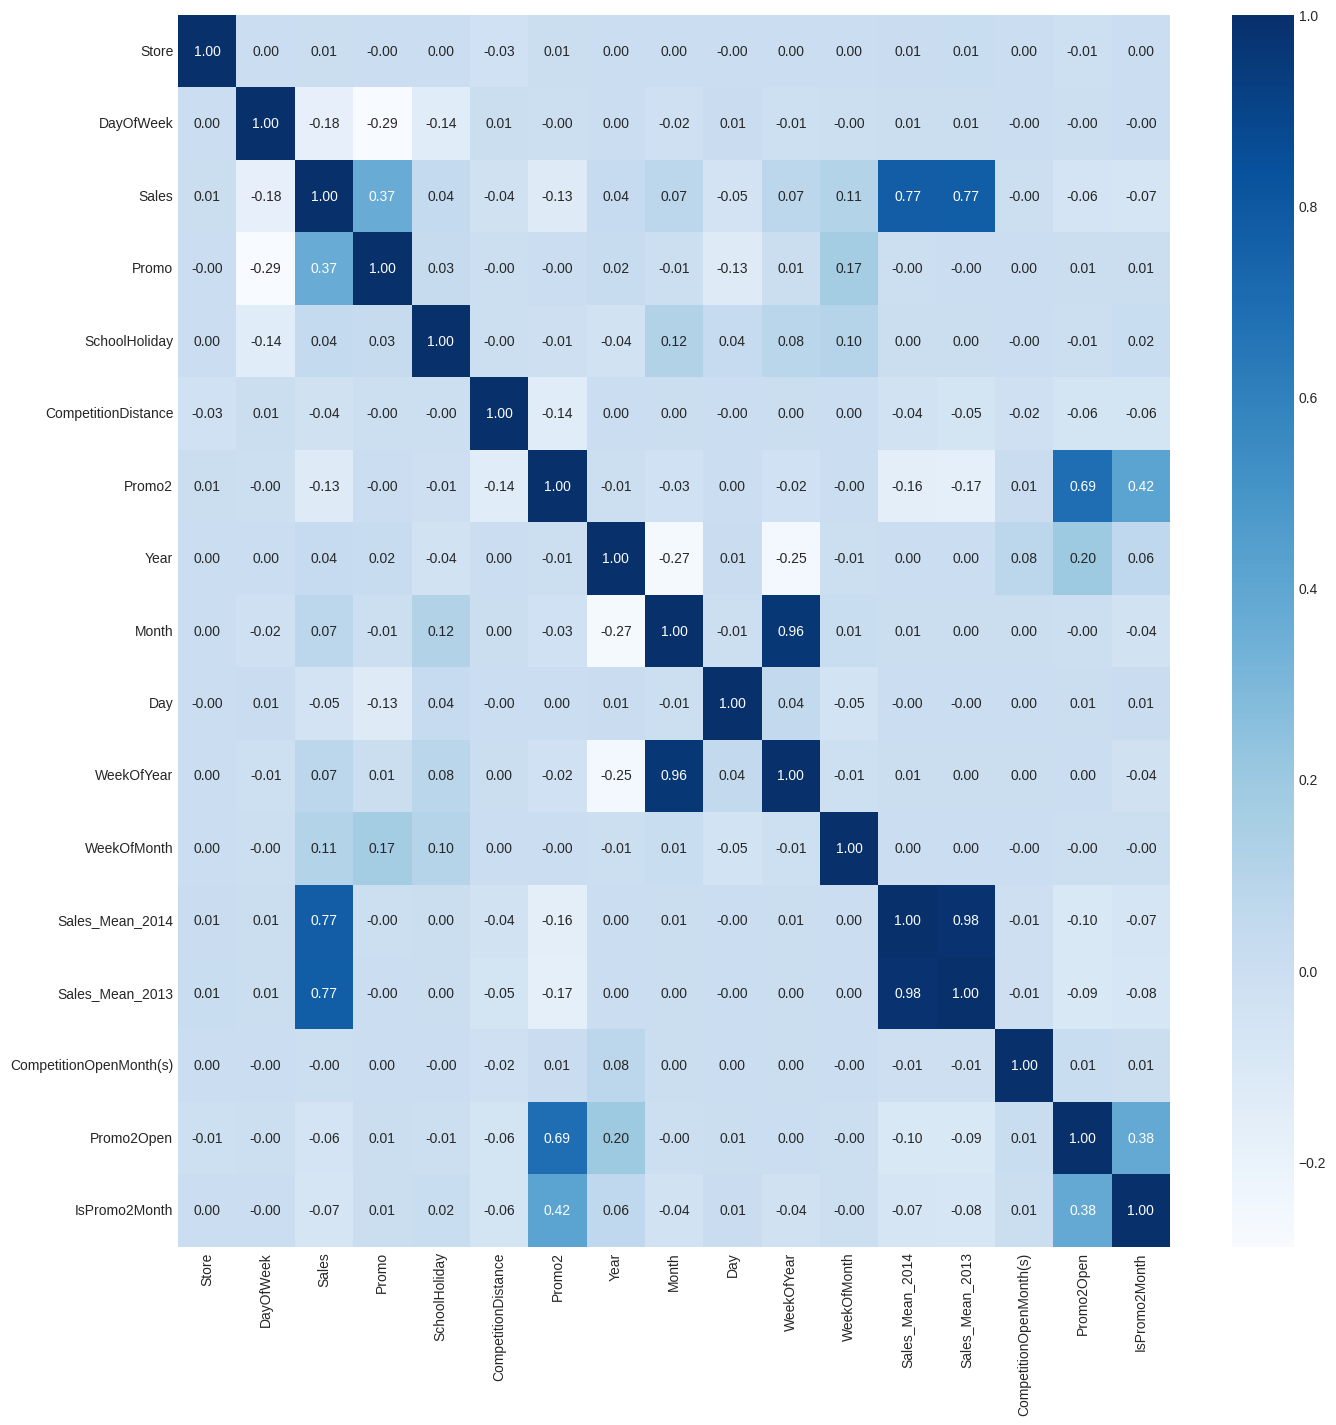

In [31]:
fig, ax = plt.subplots(figsize=(16, 16))

drop_cols_corr = ["Date", "Customers", "Open", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceYear", "Promo2SinceWeek", "PromoInterval"]
cols = [col for col in train_store_data.select_dtypes(include=[np.number]).columns if col not in drop_cols_corr]

sns.heatmap(data=train_store_data[cols].corr(), cmap="Blues", annot=True, fmt=".2f", ax=ax)
plt.show()

# **Preprocess Data**

## Input & Target Columns

### Explore input_cols to find binary, categorical and impute columns

In [32]:
target_cols = ["Sales"]

# Month has high correlation(0.96) with WeekOfYear, Sales_Mean_2013 has high correlation with Sales_Mean_2014
drop_cols = ["Date", "Month", "Customers", "Open", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceYear", "Promo2SinceWeek", "PromoInterval", "Sales_Mean_2013"]

input_cols = [col for col in train_store_data.columns if col not in target_cols + drop_cols]


Count of each column's unique values

In [33]:
train_store_data[input_cols].nunique().to_frame().T

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Day,WeekOfYear,WeekOfMonth,Sales_Mean_2014,CompetitionOpenMonth(s),Promo2Open,IsPromo2Month
0,1115,7,2,4,2,4,3,654,2,3,31,52,5,1115,336,566,2


Look for columns in input_cols that have nan

In [34]:
train_store_data[input_cols].isna().sum()[lambda x: x > 0]

,0
CompetitionDistance,2186


In [35]:
train_store_data[input_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Store                    844392 non-null  int64  
 1   DayOfWeek                844392 non-null  int64  
 2   Promo                    844392 non-null  int64  
 3   StateHoliday             844392 non-null  object 
 4   SchoolHoliday            844392 non-null  int64  
 5   StoreType                844392 non-null  object 
 6   Assortment               844392 non-null  object 
 7   CompetitionDistance      842206 non-null  float64
 8   Promo2                   844392 non-null  int64  
 9   Year                     844392 non-null  int32  
 10  Day                      844392 non-null  int32  
 11  WeekOfYear               844392 non-null  UInt32 
 12  WeekOfMonth              844392 non-null  int64  
 13  Sales_Mean_2014          844392 non-null  float64
 14  Comp

### Input Types

Split input_cols to binary, imputer, scalar and categorical

In [36]:
# # Type C
# # "DayOfWeek", "WeekOfMonth" as Categorical and Include Store
# drop_cols = ["Date", "Month", "Customers", "Open", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceYear", "Promo2SinceWeek", "PromoInterval", "Sales_Mean_2013"]
# input_cols = [col for col in train_store_data.columns if col not in target_cols + drop_cols]

# # "Promo", "SchoolHoliday", "Promo2", "IsPromo2Month"
# binary_cols = ["Promo", "SchoolHoliday", "Promo2", "IsPromo2Month"] # int64
# binary_cols = [col for col in binary_cols if col in input_cols]

# # "DayOfWeek", "Year", "WeekOfMonth" can handle as categorical or numerical (Also you can consider "WeekOfYear", "Day")
# categorical_cols = ["StateHoliday", "StoreType", "Assortment",
#                     "DayOfWeek", "WeekOfMonth"]
# categorical_cols = [col for col in categorical_cols if col not in binary_cols]

# imputer_cols = ["CompetitionDistance"]

In [37]:
# Type D
# "DayOfWeek", "WeekOfMonth" as Categorical Without Store
drop_cols = ["Store", "Date", "Month", "Customers", "Open", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceYear", "Promo2SinceWeek", "PromoInterval", "Sales_Mean_2013"]
input_cols = [col for col in train_store_data.columns if col not in target_cols + drop_cols]

# "Promo", "SchoolHoliday", "Promo2", "IsPromo2Month"
binary_cols = ["Promo", "SchoolHoliday", "Promo2", "IsPromo2Month"] # int64
binary_cols = [col for col in binary_cols if col in input_cols]

# "DayOfWeek", "Year", "WeekOfMonth" can handle as categorical or numerical (Also you can consider "WeekOfYear", "Day")
categorical_cols = ["StateHoliday", "StoreType", "Assortment",
                    "DayOfWeek", "WeekOfMonth"]
categorical_cols = [col for col in categorical_cols if col not in binary_cols]

imputer_cols = ["CompetitionDistance"]

In [38]:
# # # Type E
# # "DayOfWeek", "WeekOfMonth", "WeekOfYear", "Day" as Categorical Without Store
# drop_cols = ["Store", "Date", "Month", "Customers", "Open", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2SinceYear", "Promo2SinceWeek", "PromoInterval", "Sales_Mean_2013"]
# input_cols = [col for col in train_store_data.columns if col not in target_cols + drop_cols]

# # "Promo", "SchoolHoliday", "Promo2", "IsPromo2Month"
# binary_cols = ["Promo", "SchoolHoliday", "Promo2", "IsPromo2Month"] # int64
# binary_cols = [col for col in binary_cols if col in input_cols]

# # "DayOfWeek", "Year", "WeekOfMonth" can handle as categorical or numerical (Also you can consider "WeekOfYear", "Day")
# categorical_cols = ["StateHoliday", "StoreType", "Assortment",
#                     "DayOfWeek", "WeekOfMonth", "WeekOfYear", "Day"]
# categorical_cols = [col for col in categorical_cols if col not in binary_cols]

# imputer_cols = ["CompetitionDistance"]

Check categorical columns

In [39]:
print("Binary:", binary_cols)
print("Categorical:", categorical_cols)
print("Imputer:", imputer_cols)

Binary: ['Promo', 'SchoolHoliday', 'Promo2', 'IsPromo2Month']
Categorical: ['StateHoliday', 'StoreType', 'Assortment', 'DayOfWeek', 'WeekOfMonth']
Imputer: ['CompetitionDistance']


### ETC

In [40]:
train_store_data[categorical_cols].nunique().to_frame().T

,StateHoliday,StoreType,Assortment,DayOfWeek,WeekOfMonth
0,4,4,3,7,5


Convert binary columns from int64 to int8

In [41]:
train_store_data[binary_cols] = train_store_data[binary_cols].astype(np.int8)

## Split data to input and target

In [42]:
train_store_data.sort_values(by="Date", inplace=True)

In [43]:
input_data = train_store_data[input_cols].copy()
target_data = train_store_data[target_cols].copy()

In [44]:
input_data.head(2)

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Day,WeekOfYear,WeekOfMonth,Sales_Mean_2014,CompetitionOpenMonth(s),Promo2Open,IsPromo2Month
844391,2,0,a,1,b,b,720.0,0,2013,1,1,5,9827.665753,130.0,0.0,0
844375,2,0,a,1,b,a,1870.0,0,2013,1,1,5,7264.167123,15.0,0.0,0


In [45]:
target_data.head(2)

,Sales
844391,5961
844375,4220


In [46]:
# Check if all input_cols are in test data
test_store_data[input_cols].head(2)

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Day,WeekOfYear,WeekOfMonth,Sales_Mean_2014,CompetitionOpenMonth(s),Promo2Open,IsPromo2Month
0,4,1,0,0,c,a,1270.0,0,2015,17,38,3,4730.719472,84.0,0.000000,0
1,4,1,0,0,a,a,14130.0,1,2015,17,38,3,6864.069536,105.0,53.508197,0


## Split Train & Val

In [47]:
train_count = (len(input_data) // 100) * 75 # get 75% of rows as train data

In [48]:
X_train, y_train = input_data.iloc[:train_count].copy(), target_data.iloc[:train_count].copy()
X_val, y_val = input_data.iloc[train_count:].copy(), target_data.iloc[train_count:].copy()
X_test = test_store_data[input_cols].copy()

In [49]:
all(train_store_data[categorical_cols].nunique() == X_train[categorical_cols].nunique())

True

if return False means some of your categorical columns are going to miss in one hot encoding and you need to check and handle missing

In [50]:
print(X_train.shape)
print(y_train.shape)

print(X_val.shape)
print(y_val.shape)

(633225, 16)
(633225, 1)
(211167, 16)
(211167, 1)


In [51]:
X_train.sample(2)

,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Day,WeekOfYear,WeekOfMonth,Sales_Mean_2014,CompetitionOpenMonth(s),Promo2Open,IsPromo2Month
655466,4,0,0,1,a,a,540.0,0,2013,25,30,4,5845.208609,111.0,0.0,0
390586,2,1,0,0,a,a,2370.0,1,2014,6,19,6,6924.251701,38.0,0.0,0


## Imputer

Use max to fill CompetitionDistance nan

In [52]:
max_distance = X_train.CompetitionDistance.max()
print(max_distance)
X_train['CompetitionDistance'] = X_train['CompetitionDistance'].fillna(max_distance)
X_val['CompetitionDistance'] = X_val['CompetitionDistance'].fillna(max_distance)
X_test['CompetitionDistance'] = X_test['CompetitionDistance'].fillna(max_distance)

75860.0


In [53]:
# imputer = SimpleImputer(strategy="mean")
# imputer.fit(X_train[imputer_cols])

# X_train[imputer_cols] = imputer.transform(X_train[imputer_cols])
# X_val[imputer_cols] = imputer.transform(X_val[imputer_cols])
# X_test[imputer_cols] = imputer.transform(X_test[imputer_cols])

In [54]:
X_train.isna().sum()[lambda x: x > 0], X_val.isna().sum()[lambda x: x > 0]

(Series([], dtype: int64), Series([], dtype: int64))

In [55]:
X_test[input_cols].isna().sum()[lambda x: x > 0]

,0


## One Hot Encoding

In [56]:
# Before encoding replace np.nan with string
X_train[categorical_cols] = X_train[categorical_cols].fillna("Missing").astype(str)
X_val[categorical_cols] = X_val[categorical_cols].fillna("Missing").astype(str)
X_test[categorical_cols] = X_test[categorical_cols].fillna("Missing").astype(str)

In [57]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [58]:
encoder.categories_

[array(['0', 'a', 'b', 'c'], dtype=object),
 array(['a', 'b', 'c', 'd'], dtype=object),
 array(['a', 'b', 'c'], dtype=object),
 array(['1', '2', '3', '4', '5', '6', '7'], dtype=object),
 array(['2', '3', '4', '5', '6'], dtype=object)]

In [59]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

# Replace commas and dots with safe characters (e.g., '_' or empty)
encoded_cols = [col.replace(',', '_').replace('.', '_') for col in encoded_cols]

print(encoded_cols)

['StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'WeekOfMonth_2', 'WeekOfMonth_3', 'WeekOfMonth_4', 'WeekOfMonth_5', 'WeekOfMonth_6']


In [60]:
X_train = pd.concat([
    X_train.drop(columns=categorical_cols),
    pd.DataFrame(encoder.transform(X_train[categorical_cols]), index=X_train.index, columns=encoded_cols)
], axis=1)

X_val = pd.concat([
    X_val.drop(columns=categorical_cols),
    pd.DataFrame(encoder.transform(X_val[categorical_cols]), index=X_val.index, columns=encoded_cols)
], axis=1)

X_test = pd.concat([
    X_test.drop(columns=categorical_cols),
    pd.DataFrame(encoder.transform(X_test[categorical_cols]), index=X_test.index, columns=encoded_cols)
], axis=1)

In [61]:
print(X_train.columns.tolist())

['Promo', 'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'Year', 'Day', 'WeekOfYear', 'Sales_Mean_2014', 'CompetitionOpenMonth(s)', 'Promo2Open', 'IsPromo2Month', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7', 'WeekOfMonth_2', 'WeekOfMonth_3', 'WeekOfMonth_4', 'WeekOfMonth_5', 'WeekOfMonth_6']


In [62]:
X_train.head(2)

,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Day,WeekOfYear,Sales_Mean_2014,CompetitionOpenMonth(s),Promo2Open,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,WeekOfMonth_6
844391,0,1,720.0,0,2013,1,1,9827.665753,130.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
844375,0,1,1870.0,0,2013,1,1,7264.167123,15.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Normalization
Using feature scaling like StandardScaler or MinMaxScaler won’t ruin XGBoost, but it’s unnecessary and can be harmless or slightly inefficient, depending on the context.

**Tree-based models** like XGBoost, Random Forests, and LightGBM:

* **Don’t require features to be scaled**

In [63]:
# scalar_model = StandardScaler().fit(X_train[scalar_cols])

# X_train[scalar_cols] = scalar_model.transform(X_train[scalar_cols])
# X_val[scalar_cols] = scalar_model.transform(X_val[scalar_cols])
# X_test[scalar_cols] = scalar_model.transform(X_test[scalar_cols])
# X_train[scalar_cols].sample(2)

## Final checks

In [64]:
X_train[encoded_cols + binary_cols] = X_train[encoded_cols + binary_cols].astype(np.int8)
X_val[encoded_cols + binary_cols] = X_val[encoded_cols + binary_cols].astype(np.int8)

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 633225 entries, 844391 to 211781
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Promo                    633225 non-null  int8   
 1   SchoolHoliday            633225 non-null  int8   
 2   CompetitionDistance      633225 non-null  float64
 3   Promo2                   633225 non-null  int8   
 4   Year                     633225 non-null  int32  
 5   Day                      633225 non-null  int32  
 6   WeekOfYear               633225 non-null  UInt32 
 7   Sales_Mean_2014          633225 non-null  float64
 8   CompetitionOpenMonth(s)  633225 non-null  float64
 9   Promo2Open               633225 non-null  float64
 10  IsPromo2Month            633225 non-null  int8   
 11  StateHoliday_0           633225 non-null  int8   
 12  StateHoliday_a           633225 non-null  int8   
 13  StateHoliday_b           633225 non-null  int8   
 14  Stat

In [66]:
X_train.head()

,Promo,SchoolHoliday,CompetitionDistance,Promo2,Year,Day,WeekOfYear,Sales_Mean_2014,CompetitionOpenMonth(s),Promo2Open,...,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,WeekOfMonth_2,WeekOfMonth_3,WeekOfMonth_4,WeekOfMonth_5,WeekOfMonth_6
844391,0,1,720.0,0,2013,1,1,9827.665753,130.0,0.0,...,0,0,0,0,0,0,0,0,1,0
844375,0,1,1870.0,0,2013,1,1,7264.167123,15.0,0.0,...,0,0,0,0,0,0,0,0,1,0
844376,0,1,210.0,0,2013,1,1,12087.079452,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
844377,0,1,1180.0,0,2013,1,1,20656.736986,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
844378,0,1,3640.0,1,2013,1,1,4117.463014,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [67]:
all(X_test.columns == X_train.columns)

True

# **Train Functions**

In [68]:
def cal_rmspe(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    percentage_errors = ((y_true[mask] - y_pred[mask]) / y_true[mask]) ** 2
    return np.sqrt(np.mean(percentage_errors))

In [69]:
def try_model(model):
    # Fit the model
    model.fit(X_train, y_train.iloc[:, 0])

    # Generate predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Compute RMSPE
    train_rmspe = cal_rmspe(y_train.iloc[:, 0], train_preds)
    val_rmspe = cal_rmspe(y_val.iloc[:, 0], val_preds)

    # Compute RMSE
    train_rmse = root_mean_squared_error(y_train.iloc[:, 0], train_preds)
    val_rmse = root_mean_squared_error(y_val.iloc[:, 0], val_preds)

    print(f"Model Parameters: {[(key, value) for key, value in model.get_params().items() if value]}")
    print("RMSPE train, val:", train_rmspe, val_rmspe)
    print("RMSE train, val:", train_rmse, val_rmse)

# **XGBoost**

## Info

Now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

1. The average value of the target column and uses as an initial prediction every input.
2. The residuals (difference) of the predictions with the targets are computed.
3. A decision tree of limited depth is trained to **predict just the residuals** for each input.
4. Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
5. Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
6. Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.

> **EXERCISE**: Can you describe in your own words how a gradient boosting machine is different from a random forest?


For a mathematical explanation of gradient boosting, check out the following resources:

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
- [Video Tutorials on StatQuest](https://www.youtube.com/watch?v=3CC4N4z3GJc&list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6)

Here's a visual representation of gradient boosting:

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)



## Training

To train a GBM, we can use the `XGBRegressor` class from the [`XGBoost`](https://xgboost.readthedocs.io/en/latest/) library.

In [70]:
%%time
model = XGBRegressor(random_state=42, n_jobs=-1)
try_model(model)
"""
Type C
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.22094482082332456 0.1971159647951788
RMSE train, val: 874.3885498046875 1225.0906982421875
CPU times: user 26.2 s, sys: 83.4 ms, total: 26.3 s
Wall time: 18.4 s

Type D 	✅
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2170295869721767 0.19663837786059632
RMSE train, val: 888.4384765625 1237.4638671875
CPU times: user 25.3 s, sys: 104 ms, total: 25.4 s
Wall time: 15.5 s

Type E
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.23256818307839947 0.21103052778385006
RMSE train, val: 940.45703125 1312.849853515625
CPU times: user 47.2 s, sys: 518 ms, total: 47.7 s
Wall time: 29.9 s
"""

Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2220565701838346 0.198823439998647
RMSE train, val: 897.3629760742188 1211.9102783203125
CPU times: user 20.9 s, sys: 71.2 ms, total: 21 s
Wall time: 12.4 s


"\nType C\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.22094482082332456 0.1971159647951788\nRMSE train, val: 874.3885498046875 1225.0906982421875\nCPU times: user 26.2 s, sys: 83.4 ms, total: 26.3 s\nWall time: 18.4 s\n\nType D \t✅\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.2170295869721767 0.19663837786059632\nRMSE train, val: 888.4384765625 1237.4638671875\nCPU times: user 25.3 s, sys: 104 ms, total: 25.4 s\nWall time: 15.5 s\n\nType E\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.23256818307839947 0.21103052778385006\nRMSE train, val: 940.45703125 1312.849853515625\nCPU times: user 47.2 s, sys: 518 ms, total: 47.7 s\nWall time: 29.9 s\n"

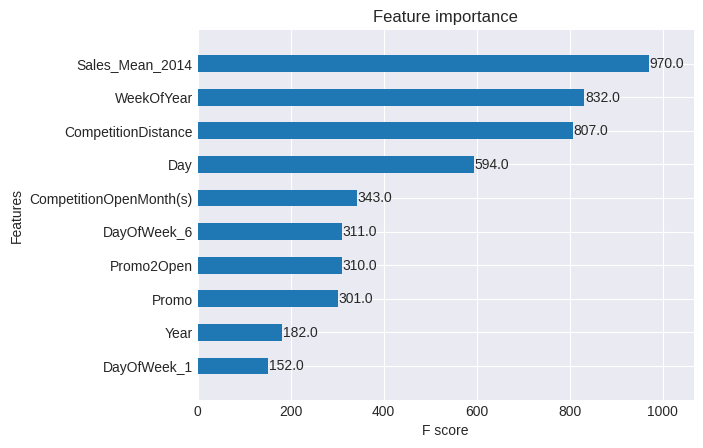

In [71]:
plot_importance(model, height=0.5, max_num_features=10)
plt.show()

## Plot XGBoost

We can visualize individual trees using `plot_tree` (note: this requires the `graphviz` library to be installed).

In [72]:
plot_model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=3, n_estimators=5)
try_model(plot_model)

Model Parameters: [('objective', 'reg:squarederror'), ('max_depth', 3), ('missing', nan), ('n_estimators', 5), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.3695101565864843 0.31010360049418334
RMSE train, val: 1624.4886474609375 1740.518798828125


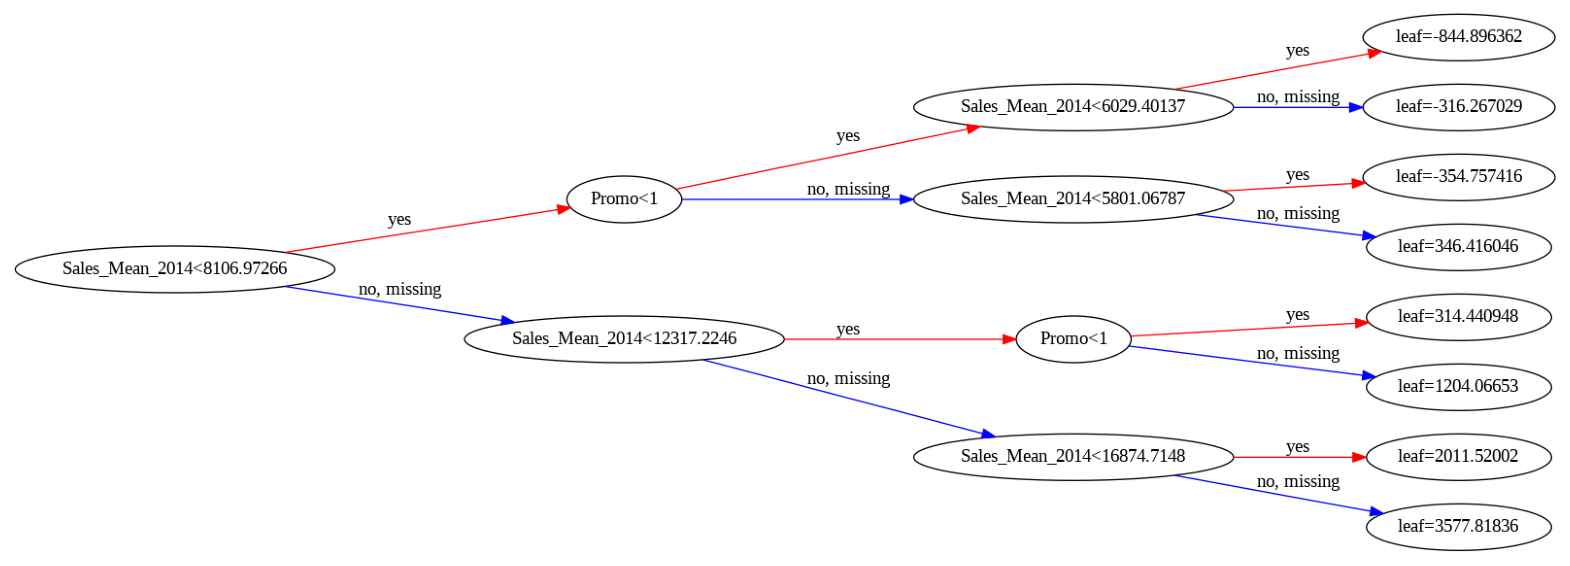

In [73]:
fig, ax = plt.subplots(figsize=(20, 30))
plot_tree(plot_model, rankdir='LR', num_trees=0, ax=ax);

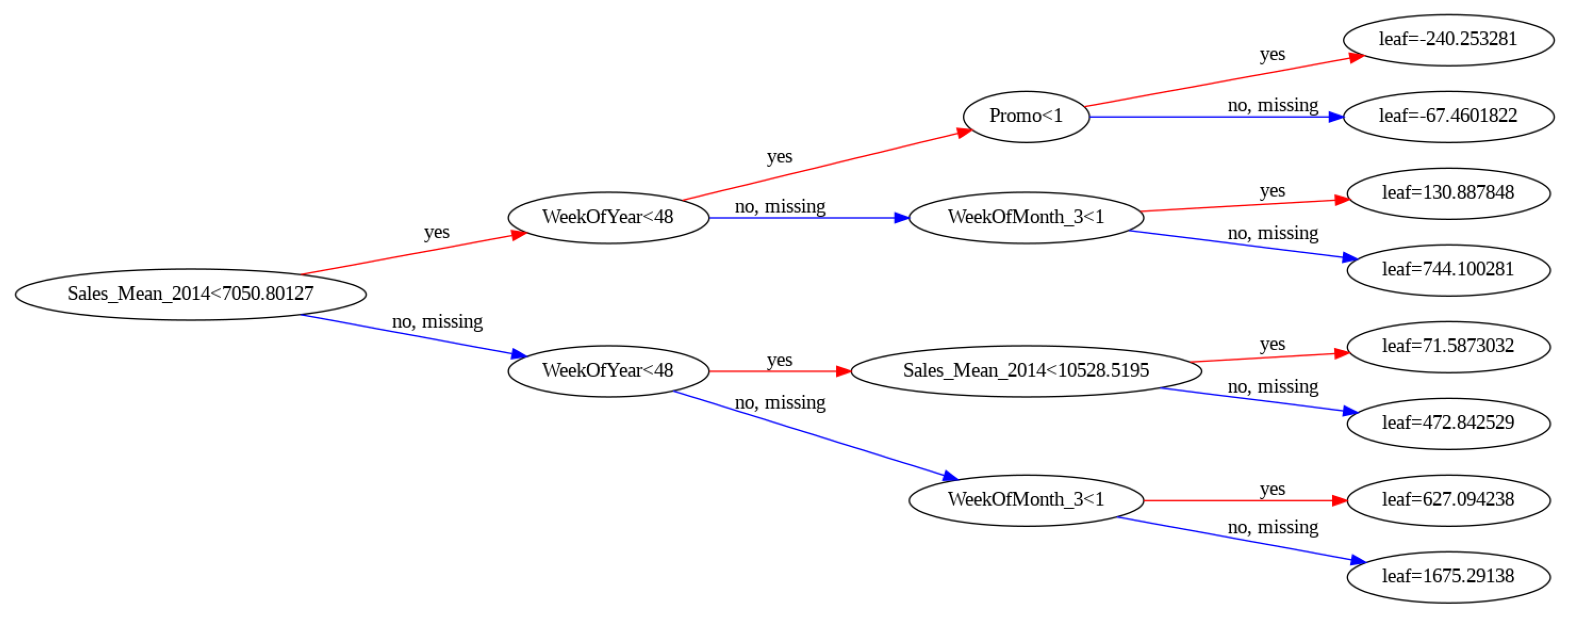

In [74]:
fig, ax = plt.subplots(figsize=(20, 30))
plot_tree(plot_model, rankdir='LR', num_trees=4, ax=ax);

Notice how the trees only compute residuals, and not the actual target value. We can also visualize the tree as text.

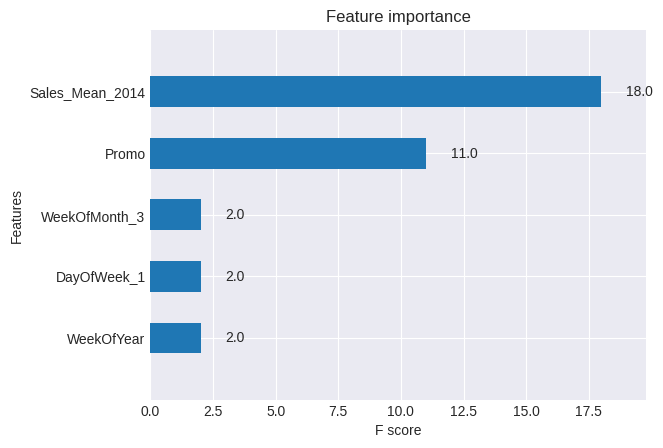

In [75]:
plot_importance(plot_model, height=0.5)
plt.show()

You can print each tree in textual format

In [76]:
Trees = plot_model.get_booster().get_dump()

In [77]:
len(Trees)

5

# **Hyperparameter Tuning and Regularization**

Just like other machine learning models, there are several hyperparameters we can to adjust the capacity of model and reduce overfitting.

<img src="https://i.imgur.com/EJCrSZw.png" width="480">

Check out the following resources to learn more about hyperparameter supported by XGBoost:

- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html

Start small :)

## `n_estimators`

The number of trees to be created. More trees = greater capacity of the model.


In [78]:
# model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=8)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 8), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.30822134144852065 0.24909863158078843
RMSE train, val: 1237.26806640625 1361.929443359375
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 8), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.30822134144852065 0.24909863158078843\nRMSE train, val: 1237.26806640625 1361.929443359375\n"

In [79]:
# model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=32)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 32), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.24899957871037035 0.21378676918959283
RMSE train, val: 1027.278564453125 1242.9833984375
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 32), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.24899957871037035 0.21378676918959283\nRMSE train, val: 1027.278564453125 1242.9833984375\n"

In [80]:
# model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=128)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 128), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2162551391869174 0.19301458418485667 ✅
RMSE train, val: 862.5458984375 1197.31103515625
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 128), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.2162551391869174 0.19301458418485667 ✅\nRMSE train, val: 862.5458984375 1197.31103515625\n"

In [81]:
# model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=256)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 256), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2040000076711908 0.1837719412434495
RMSE train, val: 766.6558227539062 1170.7711181640625 ❌
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 256), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.2040000076711908 0.1837719412434495 \nRMSE train, val: 766.6558227539062 1170.7711181640625 ❌ \n"

In [82]:
# %%time
# model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=512)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 512), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.19266857415249158 0.181139169187161
RMSE train, val: 676.1431274414062 1170.8621826171875 ❌
CPU times: user 1min 14s, sys: 119 ms, total: 1min 14s
Wall time: 46.6 s
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('missing', nan), ('n_estimators', 512), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.19266857415249158 0.181139169187161\nRMSE train, val: 676.1431274414062 1170.8621826171875 ❌ \nCPU times: user 1min 14s, sys: 119 ms, total: 1min 14s\nWall time: 46.6 s\n"

## `max_depth`

In [83]:
# model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=4, n_estimators=10)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('max_depth', 4), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.3131377328625293 0.2585044995190054
RMSE train, val: 1302.605712890625 1427.0069580078125  ❌
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('max_depth', 4), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.3131377328625293 0.2585044995190054\nRMSE train, val: 1302.605712890625 1427.0069580078125  ❌\n"

In [84]:
# model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=6, n_estimators=10)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('max_depth', 6), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.30039304768751884 0.24130462273129613
RMSE train, val: 1195.07177734375 1331.0540771484375 ✅
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('max_depth', 6), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.30039304768751884 0.24130462273129613\nRMSE train, val: 1195.07177734375 1331.0540771484375 ✅\n"

In [85]:
# model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=8, n_estimators=10)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('max_depth', 8), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2614983763784118 0.22976554362748053
RMSE train, val: 1082.2684326171875 1330.7587890625  ❌
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('max_depth', 8), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.2614983763784118 0.22976554362748053\nRMSE train, val: 1082.2684326171875 1330.7587890625  ❌\n"

In [86]:
# %%time
# model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=10, n_estimators=10)
# try_model(model)
"""
Model Parameters: [('objective', 'reg:squarederror'), ('max_depth', 10), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.23335778132843787 0.21485365274748874
RMSE train, val: 966.2091674804688 1304.6619873046875  ❌
CPU times: user 8.12 s, sys: 20.9 ms, total: 8.15 s
Wall time: 8.85 s
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('max_depth', 10), ('missing', nan), ('n_estimators', 10), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.23335778132843787 0.21485365274748874\nRMSE train, val: 966.2091674804688 1304.6619873046875  ❌\nCPU times: user 8.12 s, sys: 20.9 ms, total: 8.15 s\nWall time: 8.85 s\n"

## `learning_rate`

The scaling factor to be applied to the prediction of each tree. A very high learning rate (close to 1) will lead to overfitting, and a low learning rate (close to 0) will lead to underfitting.

In [112]:
# try_model(XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.01, n_estimators=50))
"""
Model Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.01), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.4758458837737989 0.4118003684832854
RMSE train, val: 2159.921875 2268.233154296875
"""

" \nModel Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.01), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.4758458837737989 0.4118003684832854\nRMSE train, val: 2159.921875 2268.233154296875\n"

In [113]:
# try_model(XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.1, n_estimators=50))
"""
Model Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.1), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.27733914357521394 0.23381987493365808
RMSE train, val: 1113.732666015625 1294.198486328125 ✅
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.1), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.27733914357521394 0.23381987493365808\nRMSE train, val: 1113.732666015625 1294.198486328125 ✅\n"

In [114]:
# try_model(XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.3, n_estimators=50))
"""
Model Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.3), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2379651185343946 0.20636778622081542
RMSE train, val: 977.5365600585938 1220.005859375
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.3), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.2379651185343946 0.20636778622081542\nRMSE train, val: 977.5365600585938 1220.005859375\n"

In [115]:
# try_model(XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.9, n_estimators=50))
"""
Model Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.9), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.20518894670174775 0.20783356976464454
RMSE train, val: 896.5396728515625 1322.050537109375
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.9), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.20518894670174775 0.20783356976464454\nRMSE train, val: 896.5396728515625 1322.050537109375\n"

In [116]:
# try_model(XGBRegressor(random_state=42, n_jobs=-1, learning_rate=0.99, n_estimators=50))
"""
Model Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.99), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2270092598249781 0.22371089806501868
RMSE train, val: 892.9318237304688 1355.1544189453125
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.99), ('missing', nan), ('n_estimators', 50), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.2270092598249781 0.22371089806501868\nRMSE train, val: 892.9318237304688 1355.1544189453125\n"

## `booster`

Instead of using Decision Trees, XGBoost can also train a linear model for each iteration. This can be configured using `booster`.

In [92]:
model = XGBRegressor(random_state=42, n_jobs=-1, booster="gblinear")
try_model(model)

Model Parameters: [('objective', 'reg:squarederror'), ('booster', 'gblinear'), ('missing', nan), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.3188818102871426 0.2653477429492037
RMSE train, val: 1442.979736328125 1583.053955078125


##  .
> **EXERCISE**: Exeperiment with other hyperparameters like `gamma`, `min_child_weight`, `max_delta_step`, `subsample`, `colsample_bytree` etc. and find their optimal values. Learn more about them here: https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

## Putting it Together and Making Predictions

Let's train a final model on the entire training set with custom hyperparameters.

In [121]:
# Test
%%time
model = XGBRegressor(random_state=42,
                     n_jobs=-1,
                     max_depth=6,
                     n_estimators=128,
                     learning_rate=0.1,)

try_model(model)

Model Parameters: [('objective', 'reg:squarederror'), ('learning_rate', 0.1), ('max_depth', 6), ('missing', nan), ('n_estimators', 128), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.2448180244357096 0.21104272354333858
RMSE train, val: 1000.9412841796875 1233.2022705078125
CPU times: user 27.8 s, sys: 95.4 ms, total: 27.9 s
Wall time: 18.6 s


In [93]:
# %%time
# model = XGBRegressor(random_state=42,
#                      n_jobs=-1,
#                      max_depth=8,
#                      n_estimators=1024,
#                      learning_rate=0.1,
#                      device="gpu")

# try_model(model)

"""
Model Parameters: [('objective', 'reg:squarederror'), ('device', 'gpu'), ('learning_rate', 0.1), ('max_depth', 8), ('missing', nan), ('n_estimators', 1024), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.16761967577848022 0.18352504933810768
RMSE train, val: 561.0724487304688 1204.5205078125
CPU times: user 13.9 s, sys: 204 ms, total: 14.1 s
Wall time: 13.4 s

Model Parameters: [('objective', 'reg:squarederror'), ('device', 'gpu'), ('learning_rate', 0.1), ('max_depth', 8), ('missing', nan), ('n_estimators', 10000), ('n_jobs', -1), ('random_state', 42)]
RMSPE train, val: 0.0842933381162472 0.18396931702379524
RMSE train, val: 273.42608642578125 1222.0760498046875
CPU times: user 1min 43s, sys: 1.87 s, total: 1min 44s
Wall time: 1min 46s
"""

"\nModel Parameters: [('objective', 'reg:squarederror'), ('device', 'gpu'), ('learning_rate', 0.1), ('max_depth', 8), ('missing', nan), ('n_estimators', 1024), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.16761967577848022 0.18352504933810768\nRMSE train, val: 561.0724487304688 1204.5205078125\nCPU times: user 13.9 s, sys: 204 ms, total: 14.1 s\nWall time: 13.4 s\n\nModel Parameters: [('objective', 'reg:squarederror'), ('device', 'gpu'), ('learning_rate', 0.1), ('max_depth', 8), ('missing', nan), ('n_estimators', 10000), ('n_jobs', -1), ('random_state', 42)]\nRMSPE train, val: 0.0842933381162472 0.18396931702379524\nRMSE train, val: 273.42608642578125 1222.0760498046875\nCPU times: user 1min 43s, sys: 1.87 s, total: 1min 44s\nWall time: 1min 46s\n"

## Predict Test

In [117]:
test_pred = model.predict(X_test)
test_pred

array([ 4537.4976,  7541.499 ,  9402.345 , ...,  5267.854 , 19902.33  ,
        6081.8823], dtype=float32)

In [118]:
# Handle Sales in samples that store is closed
sample_submission_data["Sales"] = test_pred * test_store_data["Open"].fillna(0)

In [119]:
sample_submission_data.describe()

,Id,Sales
count,41088.000000,41088.000000
mean,20544.500000,5713.534765
std,11861.228267,3417.587413
min,1.000000,0.000000
25%,10272.750000,4113.082520
50%,20544.500000,5735.515625
75%,30816.250000,7534.178467
max,41088.000000,29127.001953


In [120]:
sample_submission_data.to_csv("submission_0_6_10_000_lr0_1.csv", index=None)

# **KFold & TimeSeriesSplit**
standard K-Fold cross-validation is not appropriate for time series data.

If you use K-Fold on time series, make sure to use **TimeSeriesSplit** from sklearn.model_selection

Good for small datasets.

K-fold cross validation ([source](https://vitalflux.com/k-fold-cross-validation-python-example/)):

![](https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-15-at-11.13.53-AM.png)

Now, we can use the `KFold` utility to create the different training/validations splits and train a separate model for each fold.

During cross-validation:

* Fit a separate encoder per fold on each training fold.

* Use it only for that fold’s validation set.

After cross-validation (final model):

* Fit one final encoder on the entire training set.

* Save that encoder.

* Use it to transform all new/unseen/test data.

## Function to do all preprocessing

In [98]:
def preprocessing(X_t, X_v):
    # Impute
    max_distance_temp = X_t.CompetitionDistance.max()
    X_t['CompetitionDistance'] = X_t['CompetitionDistance'].fillna(max_distance_temp)
    X_v['CompetitionDistance'] = X_v['CompetitionDistance'].fillna(max_distance_temp)

    # imputer_temp = SimpleImputer(strategy="mean")
    # imputer_temp.fit(X_t[imputer_cols])

    # X_t[imputer_cols] = imputer_temp.transform(X_t[imputer_cols])
    # X_v[imputer_cols] = imputer_temp.transform(X_v[imputer_cols])

    # encode
    # Before encoding replace np.nan with string
    X_t[categorical_cols] = X_t[categorical_cols].fillna("Missing").astype(str)
    X_v[categorical_cols] = X_v[categorical_cols].fillna("Missing").astype(str)

    encoder_temp = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder_temp.fit(X_t[categorical_cols])

    encoded_cols_temp = list(encoder_temp.get_feature_names_out(categorical_cols))
    # Replace commas and dots with safe characters (e.g., '_' or empty)
    encoded_cols_temp = [col.replace(',', '_').replace('.', '_') for col in encoded_cols_temp]

    X_t = pd.concat([
        X_t.drop(columns=categorical_cols),
        pd.DataFrame(encoder_temp.transform(X_t[categorical_cols]), index=X_t.index, columns=encoded_cols_temp)
      ], axis=1)

    X_v = pd.concat([
        X_v.drop(columns=categorical_cols),
        pd.DataFrame(encoder_temp.transform(X_v[categorical_cols]), index=X_v.index, columns=encoded_cols_temp)
    ], axis=1)


    # scalar_model_temp = StandardScaler().fit(X_t[scalar_cols])

    # X_train[scalar_cols] = scalar_model_temp.transform(X_t[scalar_cols])
    # X_v[scalar_cols] = scalar_model_temp.transform(X_v[scalar_cols])

    X_t[encoded_cols_temp + binary_cols] = X_t[encoded_cols_temp + binary_cols].astype(np.int8)
    X_v[encoded_cols_temp + binary_cols] = X_v[encoded_cols_temp + binary_cols].astype(np.int8)

    return X_t, X_v

## Use KFold

In [99]:
from sklearn.model_selection import KFold

In [100]:
def train_and_evaluate(X_train_p, y_train_kf, X_val_p, y_val_kf, **params):
    model_kf = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model_kf.fit(X_train_p, y_train_kf.iloc[:, 0])
    train_rmspe = cal_rmspe(model_kf.predict(X_train_p), y_train_kf.iloc[:, 0])
    val_rmspe = cal_rmspe(model_kf.predict(X_val_p), y_val_kf.iloc[:, 0])
    return model_kf, train_rmspe, val_rmspe

In [101]:
# %%time
# kfold = KFold(n_splits=5)
# train_rmspe_list = []
# val_rmspe_list = []
# models = []

# for train_idxs, val_idxs in kfold.split(train_store_data):
#     X_train_kf, y_train_kf = input_data.iloc[train_idxs].copy(), target_data.iloc[train_idxs].copy()
#     X_val_kf, y_val_kf = input_data.iloc[val_idxs].copy(), target_data.iloc[val_idxs].copy()

#     X_train_p, X_val_p = preprocessing(X_train_kf.copy(), X_val_kf.copy())

#     model_kf, train_rmspe, val_rmspe = train_and_evaluate(X_train_p,
#                                                      y_train_kf,
#                                                      X_val_p,
#                                                      y_val_kf,
#                                                      max_depth=8,
#                                                      n_estimators=1024,
#                                                      learning_rate=0.1,
#                                                      device="gpu"
#                                                      )
#     train_rmspe_list.append(train_rmspe)
#     val_rmspe_list.append(val_rmspe)
#     models.append([model_kf, X_train_p.columns])
#     print('Train RMSPE: {}, Validation RMSPE: {}'.format(train_rmspe, val_rmspe))


# print("\nMean Train RMSPE:", np.mean(train_rmspe_list))
# print("Mean Validation RMSPE:", np.mean(val_rmspe_list))

## Use TimeSeriesSplit

In [102]:
from sklearn.model_selection import TimeSeriesSplit

In [103]:
%%time
tscv = TimeSeriesSplit(n_splits=5)
train_rmspe_list = []
val_rmspe_list = []
models = []

for train_idxs, val_idxs in tscv.split(train_store_data):
    X_train_kf, y_train_kf = input_data.iloc[train_idxs].copy(), target_data.iloc[train_idxs].copy()
    X_val_kf, y_val_kf = input_data.iloc[val_idxs].copy(), target_data.iloc[val_idxs].copy()

    X_train_p, X_val_p = preprocessing(X_train_kf.copy(), X_val_kf.copy())

    model_kf, train_rmspe, val_rmspe = train_and_evaluate(X_train_p,
                                                     y_train_kf,
                                                     X_val_p,
                                                     y_val_kf,
                                                     max_depth=6,
                                                     n_estimators=32,
                                                     learning_rate=0.1,
                                                     device="gpu"
                                                     )
    train_rmspe_list.append(train_rmspe)
    val_rmspe_list.append(val_rmspe)
    models.append([model_kf, X_train_p.columns])
    print('Train RMSPE: {}, Validation RMSPE: {}'.format(train_rmspe, val_rmspe))


print("\nMean Train RMSPE:", np.mean(train_rmspe_list))
print("Mean Validation RMSPE:", np.mean(val_rmspe_list))

"""
Train RMSPE: 0.07016141875342191, Validation RMSPE: 0.18577370494461573
Train RMSPE: 0.07620420715915457, Validation RMSPE: 0.271299468551635
Train RMSPE: 0.08166207491693583, Validation RMSPE: 0.17237245376695276
Train RMSPE: 0.0837523735581053, Validation RMSPE: 0.19989919622948393
Train RMSPE: 0.08622232111720274, Validation RMSPE: 0.1605822621815697

Mean Train RMSPE: 0.07960047910096407
Mean Validation RMSPE: 0.19798541713485143
CPU times: user 1min, sys: 1.42 s, total: 1min 1s
Wall time: 58.3 s
"""

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:30] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:30] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train RMSPE: 0.17840661895897916, Validation RMSPE: 0.18199061907326125


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train RMSPE: 0.17859560071167807, Validation RMSPE: 0.2667760409494893


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:50] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:50] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train RMSPE: 0.17835954360051817, Validation RMSPE: 0.18142003942100016


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:26:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train RMSPE: 0.17672316319663325, Validation RMSPE: 0.17718984565747764


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:27:07] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:27:07] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


Train RMSPE: 0.17483013871622968, Validation RMSPE: 0.1897246608016572

Mean Train RMSPE: 0.17738301303680767
Mean Validation RMSPE: 0.1994202411805771
CPU times: user 48.2 s, sys: 1.3 s, total: 49.5 s
Wall time: 43.9 s


'\nTrain RMSPE: 0.07016141875342191, Validation RMSPE: 0.18577370494461573\nTrain RMSPE: 0.07620420715915457, Validation RMSPE: 0.271299468551635\nTrain RMSPE: 0.08166207491693583, Validation RMSPE: 0.17237245376695276\nTrain RMSPE: 0.0837523735581053, Validation RMSPE: 0.19989919622948393\nTrain RMSPE: 0.08622232111720274, Validation RMSPE: 0.1605822621815697\n\nMean Train RMSPE: 0.07960047910096407\nMean Validation RMSPE: 0.19798541713485143\nCPU times: user 1min, sys: 1.42 s, total: 1min 1s\nWall time: 58.3 s\n'

## Predict Test

Let's also define a function to average predictions from the 5 different models.

In [104]:
def predict_avg(models, inputs):
    return np.mean([model[0].predict(inputs.loc[:, model[1]]) for model in models], axis=0)

In [105]:
X_train_kf, X_test_kf = preprocessing(input_data.copy(), test_store_data[input_cols].copy())

In [106]:
print(cal_rmspe(predict_avg(models, X_train.copy()), y_train.iloc[:, 0]))
print(cal_rmspe(predict_avg(models, X_val.copy()), y_val.iloc[:, 0]))

0.17787355727597107
0.19704645040638663


In [107]:
test_pred_k_fold = predict_avg(models, X_test_kf.copy())
test_pred_k_fold

array([ 4979.652 ,  7507.1626,  9277.158 , ...,  5799.8125, 18491.902 ,
        5548.468 ], dtype=float32)

In [108]:
# Handle Sales in samples that store is closed
sample_submission_data["Sales"] = test_pred_k_fold * test_store_data["Open"].fillna(0)

In [109]:
sample_submission_data.describe()

,Id,Sales
count,41088.000000,41088.000000
mean,20544.500000,5714.676628
std,11861.228267,3281.701072
min,1.000000,0.000000
25%,10272.750000,4247.222900
50%,20544.500000,5815.022461
75%,30816.250000,7492.574707
max,41088.000000,25847.265625


In [110]:
sample_submission_data.to_csv("submission_0.csv", index=None)

# **Summary**

![](https://miro.medium.com/max/560/1*85QHtH-49U7ozPpmA5cAaw.png)

The following topics were covered in this tutorial:

- Downloading a real-world dataset from a Kaggle competition
- Performing feature engineering and prepare the dataset for training
- Training and interpreting a gradient boosting model using XGBoost
- Training with KFold cross validation and ensembling results
- Configuring the gradient boosting model and tuning hyperparamters

Check out these resources to learn more:

- https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0
- https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/
- https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor
- https://xgboost.readthedocs.io/en/latest/parameter.html
- https://www.kaggle.com/xwxw2929/rossmann-sales-top1
